In [ ]:
!pip install geopandas

import pandas as pd
import numpy as np
from scipy.stats import mstats
from scipy import stats
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
import os
import seaborn as sns
from natsort import natsorted
import folium
from google.colab import drive
drive.mount('/content/drive')
import geopandas as gpd
from shapely.geometry import Point
import pyproj
from pyproj import Transformer
from pyproj import Proj, transform

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Clustering Function to create summary dataframe for precipitation data

def process_rainfall_data(file_path):
    data = pd.read_csv(file_path, header = 12)
    with open(file_path, 'r') as file:
        lines = file.readlines()

    #Rainfall Data Dependent - Will work for UKCP18 projection files with 12 members
    for line in lines:
        if line.startswith('Area'):
            _, coordinates = line.split(',') 
            coord1, coord2 = map(float, coordinates.split())  
            break
    data_start_line = 14
    data_lines = lines[data_start_line:]
    with open('temp.csv', 'w') as f:
        f.writelines(data_lines)
    df = pd.read_csv('temp.csv')

    data_clean = data.drop(data.index[12]).reset_index(drop=True)
    # Using errors 'coerce' removes leap year values that do not exist but feature in UKCP18 dataframe e.g. 29/02/2081 (not a leap year)
    data_clean[data_clean.columns[0]] = pd.to_datetime(data_clean.iloc[:, 0], errors='coerce')
    data_clean.dropna(inplace=True)
    data_clean.set_index(data_clean.columns[0], inplace=True) 

   #Again will work for UKCP18 data with 12 members included
    member_columns = [
        "Precipitation rate (mm/day)(HadREM3-RA11M-r001i1p00000)",
        "Precipitation rate (mm/day)(HadREM3-RA11M-r001i1p01113)",
        "Precipitation rate (mm/day)(HadREM3-RA11M-r001i1p01554)",
        "Precipitation rate (mm/day)(HadREM3-RA11M-r001i1p01649)",
        "Precipitation rate (mm/day)(HadREM3-RA11M-r001i1p01843)",
        "Precipitation rate (mm/day)(HadREM3-RA11M-r001i1p01935)",
        "Precipitation rate (mm/day)(HadREM3-RA11M-r001i1p02123)",
        "Precipitation rate (mm/day)(HadREM3-RA11M-r001i1p02242)",
        "Precipitation rate (mm/day)(HadREM3-RA11M-r001i1p02305)",
        "Precipitation rate (mm/day)(HadREM3-RA11M-r001i1p02335)",
        "Precipitation rate (mm/day)(HadREM3-RA11M-r001i1p02491)",
        "Precipitation rate (mm/day)(HadREM3-RA11M-r001i1p02868)",
    ]
    summary_dfs = []
    for member_column_name in member_columns:
        chosen_member = data_clean[[member_column_name]]
        chosen_member = chosen_member.rename(columns={member_column_name: 'TP'})

        #Setting rolling window lengths
        windows = [14, 21, 28]

        #Creating a copy of the chosen_member and saving it as precip_data, then resetting the index and creating a boolean True/False if the TP value is over the 95th Percentile
        #This is then set as an integer for 0 if False and 1 if True, creating a binary series for the clustering calculation to be taken from

        #Percentile value set at 0.95 but can be changed if location/catchment dependent
        precip_data = chosen_member.copy()
        precip_data.reset_index(inplace=True)
        precip_data['is_extreme'] = precip_data['TP'] > np.quantile(precip_data['TP'], 0.95)
        precip_data['is_extreme_int'] = precip_data['is_extreme'].astype(int)
        precip_data.set_index('Date', inplace=True)

        for window in windows:
            precip_data[f'TPw{window}'] = precip_data['TP'].rolling(window=window, min_periods=1).sum()

        def time2season(date):
            month = date.month
            if 3 <= month <= 5:
                return 'spring'
            elif 6 <= month <= 8:
                return 'summer'
            elif 9 <= month <= 11:
                return 'autumn'
            else:
                return 'winter'

        precip_data['Season'] = precip_data.index.map(time2season)

        #Extreme count set at 3 to count as cluster, can be adapted for longer rolling window sizes if necessary
        min_extreme_count = 3

        for window_cluster in windows:
            precip_data[f'extreme_count_w{window_cluster}'] = precip_data['is_extreme_int'].rolling(window=window_cluster).sum()
            precip_data[f'is_cluster_w{window_cluster}'] = (precip_data[f'extreme_count_w{window_cluster}'] >= min_extreme_count).astype(int)


        precip_data['cluster_start_w14'] = (precip_data['is_cluster_w14'].diff() == 1).astype(int)
        precip_data['cluster_start_w21'] = (precip_data['is_cluster_w21'].diff() == 1).astype(int)
        precip_data['cluster_start_w28'] = (precip_data['is_cluster_w28'].diff() == 1).astype(int)

        total_clusters_w14 = precip_data['cluster_start_w14'].sum()
        total_clusters_w21 = precip_data['cluster_start_w21'].sum()
        total_clusters_w28 = precip_data['cluster_start_w28'].sum()

        #Dispersion between the clusters
        def calculate_dispersion(column):
            cluster_start_dates = precip_data[precip_data[column].diff() == 1].index
            date_differences = cluster_start_dates[1:] - cluster_start_dates[:-1]
            mean_diff = date_differences.mean().days
            std_diff = date_differences.std().days
            min_diff = date_differences.min().days
            max_diff = date_differences.max().days

            return {
                'mean': mean_diff,
                'std': std_diff,
                'min': min_diff,
                'max': max_diff
            }

        dispersion_w14 = calculate_dispersion('is_cluster_w14')
        dispersion_w21 = calculate_dispersion('is_cluster_w21')
        dispersion_w28 = calculate_dispersion('is_cluster_w28')


        #Average Precipitation in Cluster
        def average_precipitation_on_cluster(cluster_column_name):
            cluster_data = precip_data[precip_data[cluster_column_name] == 1]
            avg_precipitation = cluster_data['TP'].mean()
            return avg_precipitation

        windows = [14, 21, 28]
        averages = {}

        def rolling_window_averages(window_sizes, precip_data):
            averages = {}
            for window in window_sizes:
                cluster_column_name = f'is_cluster_w{window}'
                tp_window_column_name = f'TPw{window}'
                cluster_data = precip_data[precip_data[cluster_column_name] == 1]               
                avg_precipitation = cluster_data[tp_window_column_name].mean()
                averages[tp_window_column_name] = avg_precipitation
            return averages


        windows = [14, 21, 28]
        rw_averages = rolling_window_averages(windows, precip_data)


        def create_summary_df(windows, averages):
            summary_data = {
                'Window': [],
                'Total Cluster Amount': [],
                'Mean Dispersion': [],
                'Std Dispersion': [],
                'Min Dispersion': [],
                'Max Dispersion': [],
                'Avg P in Cluster': [],
                'Peak TP': [],
                'Avg Rolling Window P': [],
            }

            # Peak TP for the entire dataframe
            peak_tp = precip_data['TP'].max()

            for window in windows:
                cluster_column_name = f'is_cluster_w{window}'
                tp_window_column_name = f'TPw{window}'

                # Total Clusters
                if window == 14:
                    total_clusters = total_clusters_w14
                elif window == 21:
                    total_clusters = total_clusters_w21
                elif window == 28:
                    total_clusters = total_clusters_w28

                # Dispersion Statistics
                dispersion_stats = calculate_dispersion(cluster_column_name)

                # Average Precipitation
                avg_precipitation = average_precipitation_on_cluster(cluster_column_name)

                # Average Rolling Window Precipitation
                avg_rw_precipitation = rw_averages[tp_window_column_name]

                # Append to summary_data
                summary_data['Window'].append(window)
                summary_data['Total Cluster Amount'].append(total_clusters)
                summary_data['Mean Dispersion'].append(dispersion_stats['mean'])
                summary_data['Std Dispersion'].append(dispersion_stats['std'])
                summary_data['Min Dispersion'].append(dispersion_stats['min'])
                summary_data['Max Dispersion'].append(dispersion_stats['max'])
                summary_data['Avg P in Cluster'].append(avg_precipitation)
                summary_data['Peak TP'].append(peak_tp)
                summary_data['Avg Rolling Window P'].append(avg_rw_precipitation)

            summary_df = pd.DataFrame(summary_data)
            summary_df['Location/Timeframe'] = os.path.basename(file_path[:-4])
            summary_df['Coordinates'] = [(coord1, coord2)] *len(summary_df)
            return summary_df

        windows = [14, 21, 28]

        summary_df = create_summary_df(windows, averages)
        summary_dfs.append(summary_df)
            
    combined_summary_df = pd.concat(summary_dfs, ignore_index=True)
    combined_summary_df.reset_index(drop=True, inplace=True)
    combined_summary_df['Member'] = (combined_summary_df.index // len(windows)) + 1
    combined_summary_df['Member'] = combined_summary_df['Member'].astype(int)
    return combined_summary_df

In [ ]:
#Identifying the file paths for working (Can select all files in folder etc - This code was produced partly in Colab and file names were therefore specified)
file_paths = [
    '01NCL_1981_2000.csv', '01NCL_2021_2040.csv', '01NCL_2061_2080.csv',
    '02LDN_1981_2000.csv', '02LDN_2021_2040.csv', '02LDN_2061_2080.csv',
    '03MAN_1981_2000.csv', '03MAN_2021_2040.csv', '03MAN_2061_2080.csv',
    '04EDI_1981_2000.csv', '04EDI_2021_2040.csv', '04EDI_2061_2080.csv',
    '05BEL_1981_2000.csv', '05BEL_2021_2040.csv', '05BEL_2061_2080.csv',
    '06BRI_1981_2000.csv', '06BRI_2021_2040.csv', '06BRI_2061_2080.csv',
    '07GLA_1981_2000.csv', '07GLA_2021_2040.csv', '07GLA_2061_2080.csv',
    '08BIR_1981_2000.csv', '08BIR_2021_2040.csv', '08BIR_2061_2080.csv',
    '09INV_1981_2000.csv', '09INV_2021_2040.csv', '09INV_2061_2080.csv',
    '10ABE_1981_2000.csv', '10ABE_2021_2040.csv', '10ABE_2061_2080.csv',
    '11PLY_1981_2000.csv', '11PLY_2021_2040.csv', '11PLY_2061_2080.csv',
    '12OXF_1981_2000.csv', '12OXF_2021_2040.csv', '12OXF_2061_2080.csv',
    '13LAK_1981_2000.csv', '13LAK_2021_2040.csv', '13LAK_2061_2080.csv',
    '14NYM_1981_2000.csv', '14NYM_2021_2040.csv', '14NYM_2061_2080.csv',
    '15SNO_1981_2000.csv', '15SNO_2021_2040.csv', '15SNO_2061_2080.csv',
    '16CAI_1981_2000.csv', '16CAI_2021_2040.csv', '16CAI_2061_2080.csv',
    '17LOC_1981_2000.csv', '17LOC_2021_2040.csv', '17LOC_2061_2080.csv',
    '18SOU_1981_2000.csv', '18SOU_2021_2040.csv', '18SOU_2061_2080.csv',
    '19PEA_1981_2000.csv', '19PEA_2021_2040.csv', '19PEA_2061_2080.csv',
    '20YOR_1981_2000.csv', '20YOR_2021_2040.csv', '20YOR_2061_2080.csv', 
    '21NOR_1981_2000.csv', '21NOR_2021_2040.csv', '21NOR_2061_2080.csv',
    '22BRE_1981_2000.csv', '22BRE_2021_2040.csv', '22BRE_2061_2080.csv',
    '23ENN_1981_2000.csv', '23ENN_2021_2040.csv', '23ENN_2061_2080.csv',
    '24EAA_1981_2000.csv', '24EAA_2021_2040.csv', '24EAA_2061_2080.csv',
    '25PET_1981_2000.csv', '25PET_2021_2040.csv', '25PET_2061_2080.csv',
    '26WOO_1981_2000.csv', '26WOO_2021_2040.csv', '26WOO_2061_2080.csv',
    '27DOR_1981_2000.csv', '27DOR_2021_2040.csv', '27DOR_2061_2080.csv',
    '28LLA_1981_2000.csv', '28LLA_2021_2040.csv', '28LLA_2061_2080.csv',
    '29DAR_1981_2000.csv', '29DAR_2021_2040.csv', '29DAR_2061_2080.csv', 
    '30THU_1981_2000.csv', '30THU_2021_2040.csv', '30THU_2061_2080.csv',
]
#Concentating all 12 member results for each location and timeframe
all_results = pd.concat([process_rainfall_data(file_path) for file_path in file_paths], ignore_index=True)
all_results = all_results.set_index("Location/Timeframe")
all_results

Window  Total Cluster Amount  Mean Dispersion  \
Location/Timeframe                                                  
01NCL_1981_2000         14                    42              169   
01NCL_1981_2000         21                    58              124   
01NCL_1981_2000         28                    76               94   
01NCL_1981_2000         14                    50              127   
01NCL_1981_2000         21                    70              100   
...                    ...                   ...              ...   
30THU_2061_2080         21                    77               95   
30THU_2061_2080         28                    78               94   
30THU_2061_2080         14                    48              148   
30THU_2061_2080         21                    71              100   
30THU_2061_2080         28                    81               89   

                    Std Dispersion  Min Dispersion  Max Dispersion  \
Location/Timeframe                                                   
01NCL_1981_2000                144               4             516   
01NCL_1981_2000                120               4             516   
01NCL_1981_2000                 98               4             516   
01NCL_1981_2000                114               5             420   
01NCL_1981_2000                102               6             390   
...                            ...             ...             ...   
30THU_2061_2080                 97               3             418   
30THU_2061_2080                 88               2             365   
30THU_2061_2080                173               5             699   
30THU_2061_2080                126               4             699   
30THU_2061_2080                 88               2             507   

                    Avg P in Cluster     Peak TP  Avg Rolling Window P  \
Location/Timeframe                                                       
01NCL_1981_2000             5.894339  108.939660             92.924700   
01NCL_1981_2000             4.672865  108.939660            106.546402   
01NCL_1981_2000             4.027416  108.939660            118.873457   
01NCL_1981_2000             4.778039   65.751790             89.108258   
01NCL_1981_2000             4.127458   65.751790            101.239878   
...                              ...         ...                   ...   
30THU_2061_2080             5.561875   71.232810            126.601155   
30THU_2061_2080             5.085698   71.232810            150.253730   
30THU_2061_2080             7.435073   88.348206            111.172566   
30THU_2061_2080             6.082059   88.348206            137.204008   
30THU_2061_2080             5.518000   88.348206            158.449080   

                             Coordinates  Member  
Location/Timeframe                                
01NCL_1981_2000     (422500.0, 567500.0)       1  
01NCL_1981_2000     (422500.0, 567500.0)       1  
01NCL_1981_2000     (422500.0, 567500.0)       1  
01NCL_1981_2000     (422500.0, 567500.0)       2  
01NCL_1981_2000     (422500.0, 567500.0)       2  
...                                  ...     ...  
30THU_2061_2080     (312500.0, 967500.0)      11  
30THU_2061_2080     (312500.0, 967500.0)      11  
30THU_2061_2080     (312500.0, 967500.0)      12  
30THU_2061_2080     (312500.0, 967500.0)      12  
30THU_2061_2080     (312500.0, 967500.0)      12  

[3240 rows x 11 columns]

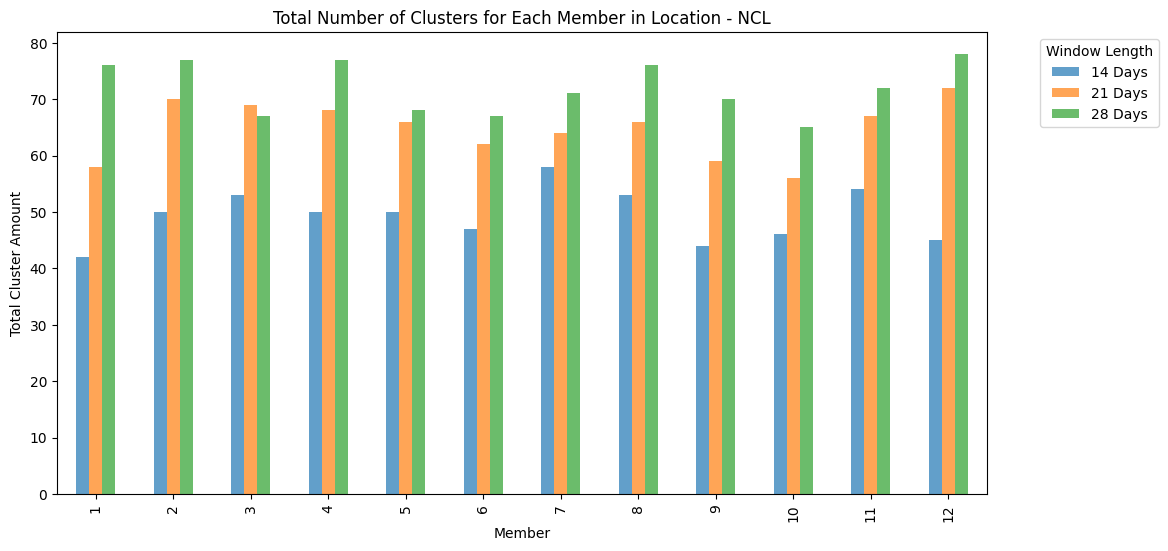

In [ ]:
NCL01_1981_2000 = all_results.loc['01NCL_1981_2000']
# Filter data for 14, 21, and 28-day windows
NCL01_1981_2000_14Window = NCL01_1981_2000[NCL01_1981_2000['Window'] == 14]
NCL01_1981_2000_21Window = NCL01_1981_2000[NCL01_1981_2000['Window'] == 21]
NCL01_1981_2000_28Window = NCL01_1981_2000[NCL01_1981_2000['Window'] == 28]

# Group the data by 'Member' and aggregate the total number of clusters
member_clusters_14 = NCL01_1981_2000_14Window.groupby('Member')['Total Cluster Amount'].sum()
member_clusters_21 = NCL01_1981_2000_21Window.groupby('Member')['Total Cluster Amount'].sum()
member_clusters_28 = NCL01_1981_2000_28Window.groupby('Member')['Total Cluster Amount'].sum()

combined_clusters = pd.concat([member_clusters_14, member_clusters_21, member_clusters_28], axis=1, keys=['14 Days', '21 Days', '28 Days'])

ax = combined_clusters.plot(kind='bar', alpha=0.7, figsize=(12, 6))
plt.xlabel('Member')
plt.ylabel('Total Cluster Amount')
plt.title('Total Number of Clusters for Each Member in Location - NCL')
plt.legend(title='Window Length', loc='upper left', bbox_to_anchor=(1.05, 1))
plt.show()



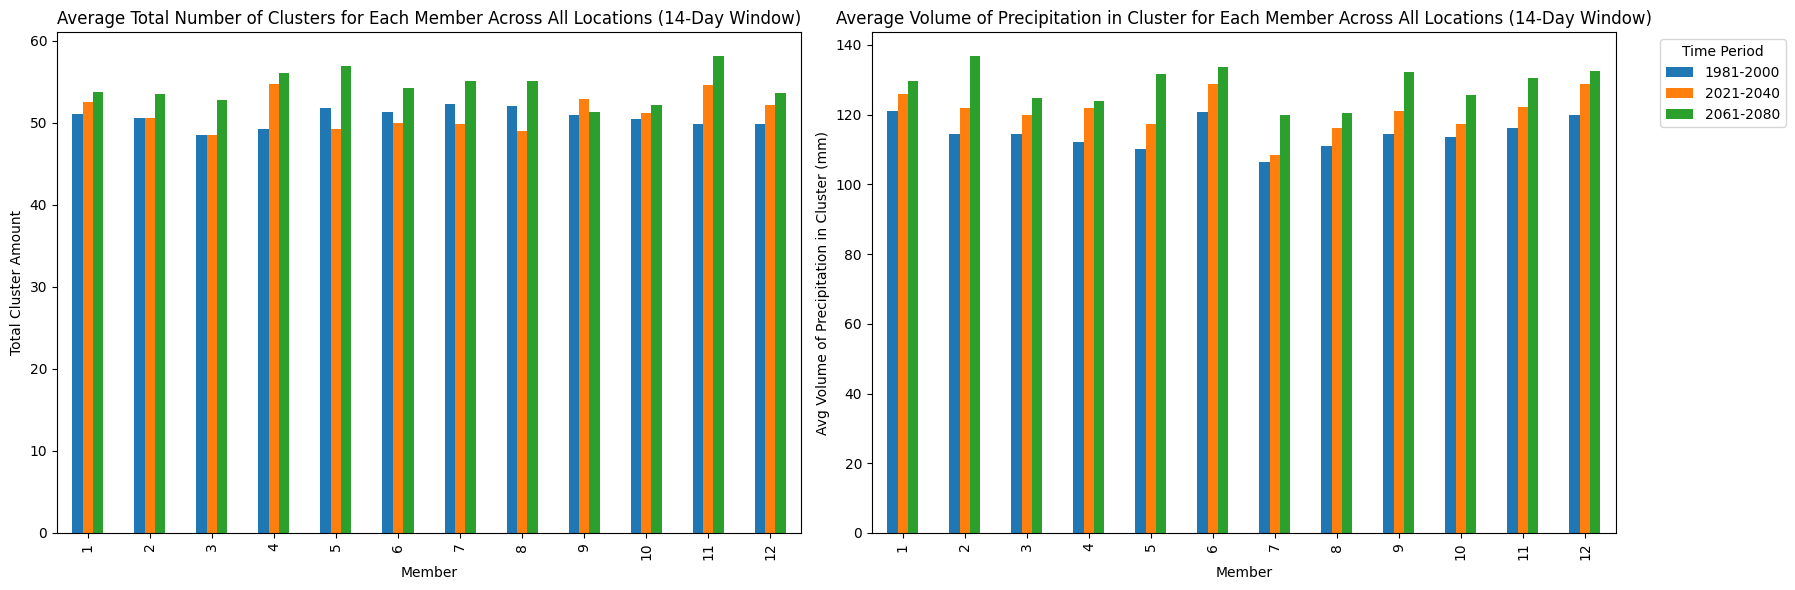

In [ ]:
# Filter data for 14-day windows and each time period
all_14Window_1981_2000 = all_results[(all_results['Window'] == 14) & (all_results.index.str.contains('1981_2000'))]
all_14Window_2021_2040 = all_results[(all_results['Window'] == 14) & (all_results.index.str.contains('2021_2040'))]
all_14Window_2061_2080 = all_results[(all_results['Window'] == 14) & (all_results.index.str.contains('2061_2080'))]

# Group the data by 'Member' and aggregate the total number of clusters for each location and time period
member_clusters_1981_2000 = all_14Window_1981_2000.groupby(['Member', 'Location/Timeframe'])['Total Cluster Amount'].mean().reset_index().groupby('Member')['Total Cluster Amount'].mean()
member_clusters_2021_2040 = all_14Window_2021_2040.groupby(['Member', 'Location/Timeframe'])['Total Cluster Amount'].mean().reset_index().groupby('Member')['Total Cluster Amount'].mean()
member_clusters_2061_2080 = all_14Window_2061_2080.groupby(['Member', 'Location/Timeframe'])['Total Cluster Amount'].mean().reset_index().groupby('Member')['Total Cluster Amount'].mean()
member_avg_precip_1981_2000 = all_14Window_1981_2000.groupby(['Member', 'Location/Timeframe'])['Avg Rolling Window P'].mean().reset_index().groupby('Member')['Avg Rolling Window P'].mean()
member_avg_precip_2021_2040 = all_14Window_2021_2040.groupby(['Member', 'Location/Timeframe'])['Avg Rolling Window P'].mean().reset_index().groupby('Member')['Avg Rolling Window P'].mean()
member_avg_precip_2061_2080 = all_14Window_2061_2080.groupby(['Member', 'Location/Timeframe'])['Avg Rolling Window P'].mean().reset_index().groupby('Member')['Avg Rolling Window P'].mean()

# Combine the data into two DataFrames
combined_avg_precip = pd.concat([member_avg_precip_1981_2000, member_avg_precip_2021_2040, member_avg_precip_2061_2080], axis=1, keys=['1981-2000', '2021-2040', '2061-2080'])
combined_clusters = pd.concat([member_clusters_1981_2000, member_clusters_2021_2040, member_clusters_2061_2080], axis=1, keys=['1981-2000', '2021-2040', '2061-2080'])

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

# Plotting the side by side plots for combined clusters and average precipitation in cluster
combined_clusters.plot(kind='bar', ax=axes[0], legend=False)
axes[0].set_xlabel('Member')
axes[0].set_ylabel('Total Cluster Amount')
axes[0].set_title('Average Total Number of Clusters for Each Member Across All Locations (14-Day Window)')
combined_avg_precip.plot(kind='bar', ax=axes[1])
axes[1].set_xlabel('Member')
axes[1].set_ylabel('Avg Volume of Precipitation in Cluster (mm)')
axes[1].set_title('Average Volume of Precipitation in Cluster for Each Member Across All Locations (14-Day Window)')

plt.legend(title='Time Period', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

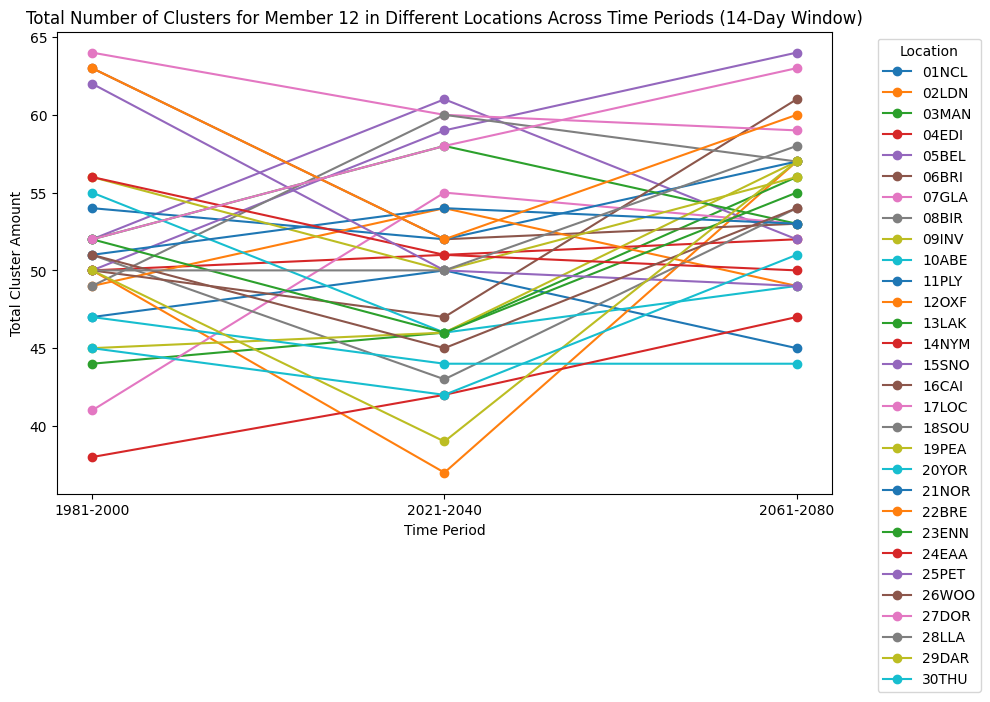

In [ ]:
#Number of clusters for all locations across time periods (member 12)

# Filter data
member12_14Window = all_results[(all_results['Window'] == 14) & (all_results['Member'] == 6)]
clusters_by_location_period = member12_14Window.groupby(['Location/Timeframe'])['Total Cluster Amount'].sum().reset_index()
clusters_pivoted = clusters_by_location_period.pivot_table(values='Total Cluster Amount', index='Location/Timeframe', columns=None)
location_names = clusters_pivoted.index.str.split('_').str[0].unique()

# Create a dictionary to store cluster amounts by location
clusters_by_location = {}
for location in location_names:
    location_data = clusters_pivoted.loc[clusters_pivoted.index.str.startswith(location)]
    clusters_by_location[location] = location_data

x_labels = ['1981-2000', '2021-2040', '2061-2080']

fig, ax = plt.subplots(figsize=(10, 6))
for location, data in clusters_by_location.items():
    ax.plot(x_labels, data.values, marker='o', label=location)
plt.xlabel('Time Period')
plt.ylabel('Total Cluster Amount')
plt.title('Total Number of Clusters for Member 12 in Different Locations Across Time Periods (14-Day Window)')
plt.legend(title='Location', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


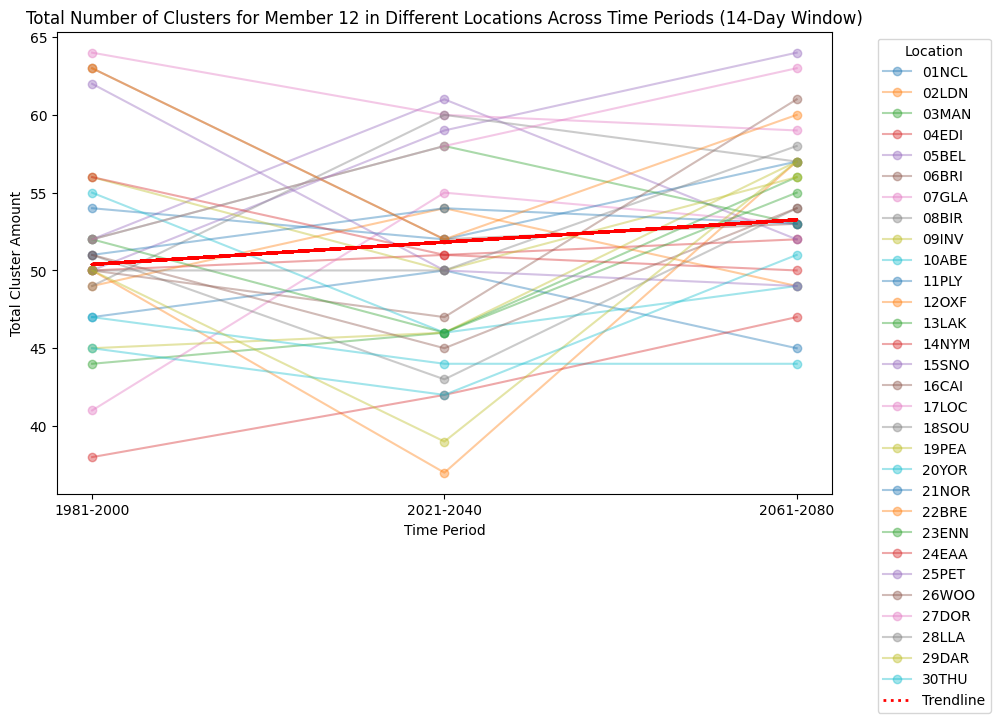

In [ ]:
#Number of clusters for all locations with trendline (member 12)
x_numeric = [0, 1, 2] 

x_values = []
y_values = []
for location, data in clusters_by_location.items():
    x_values.extend(x_numeric)
    y_values.extend(data.values)

x_values = np.array(x_values).flatten()
y_values = np.array(y_values).flatten()

# Fit a linear regression model
z = np.polyfit(x_values, y_values, 1)
p = np.poly1d(z)

fig, ax = plt.subplots(figsize=(10, 6))
for location, data in clusters_by_location.items():
    ax.plot(x_numeric, data.values, marker='o', label=location, alpha=0.4)

ax.plot(x_values, p(x_values), "r:", label='Trendline', linewidth=2)

plt.xticks(ticks=x_numeric, labels=x_labels)
plt.xlabel('Time Period')
plt.ylabel('Total Cluster Amount')
plt.title('Total Number of Clusters for Member 12 in Different Locations Across Time Periods (14-Day Window)')
plt.legend(title='Location', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


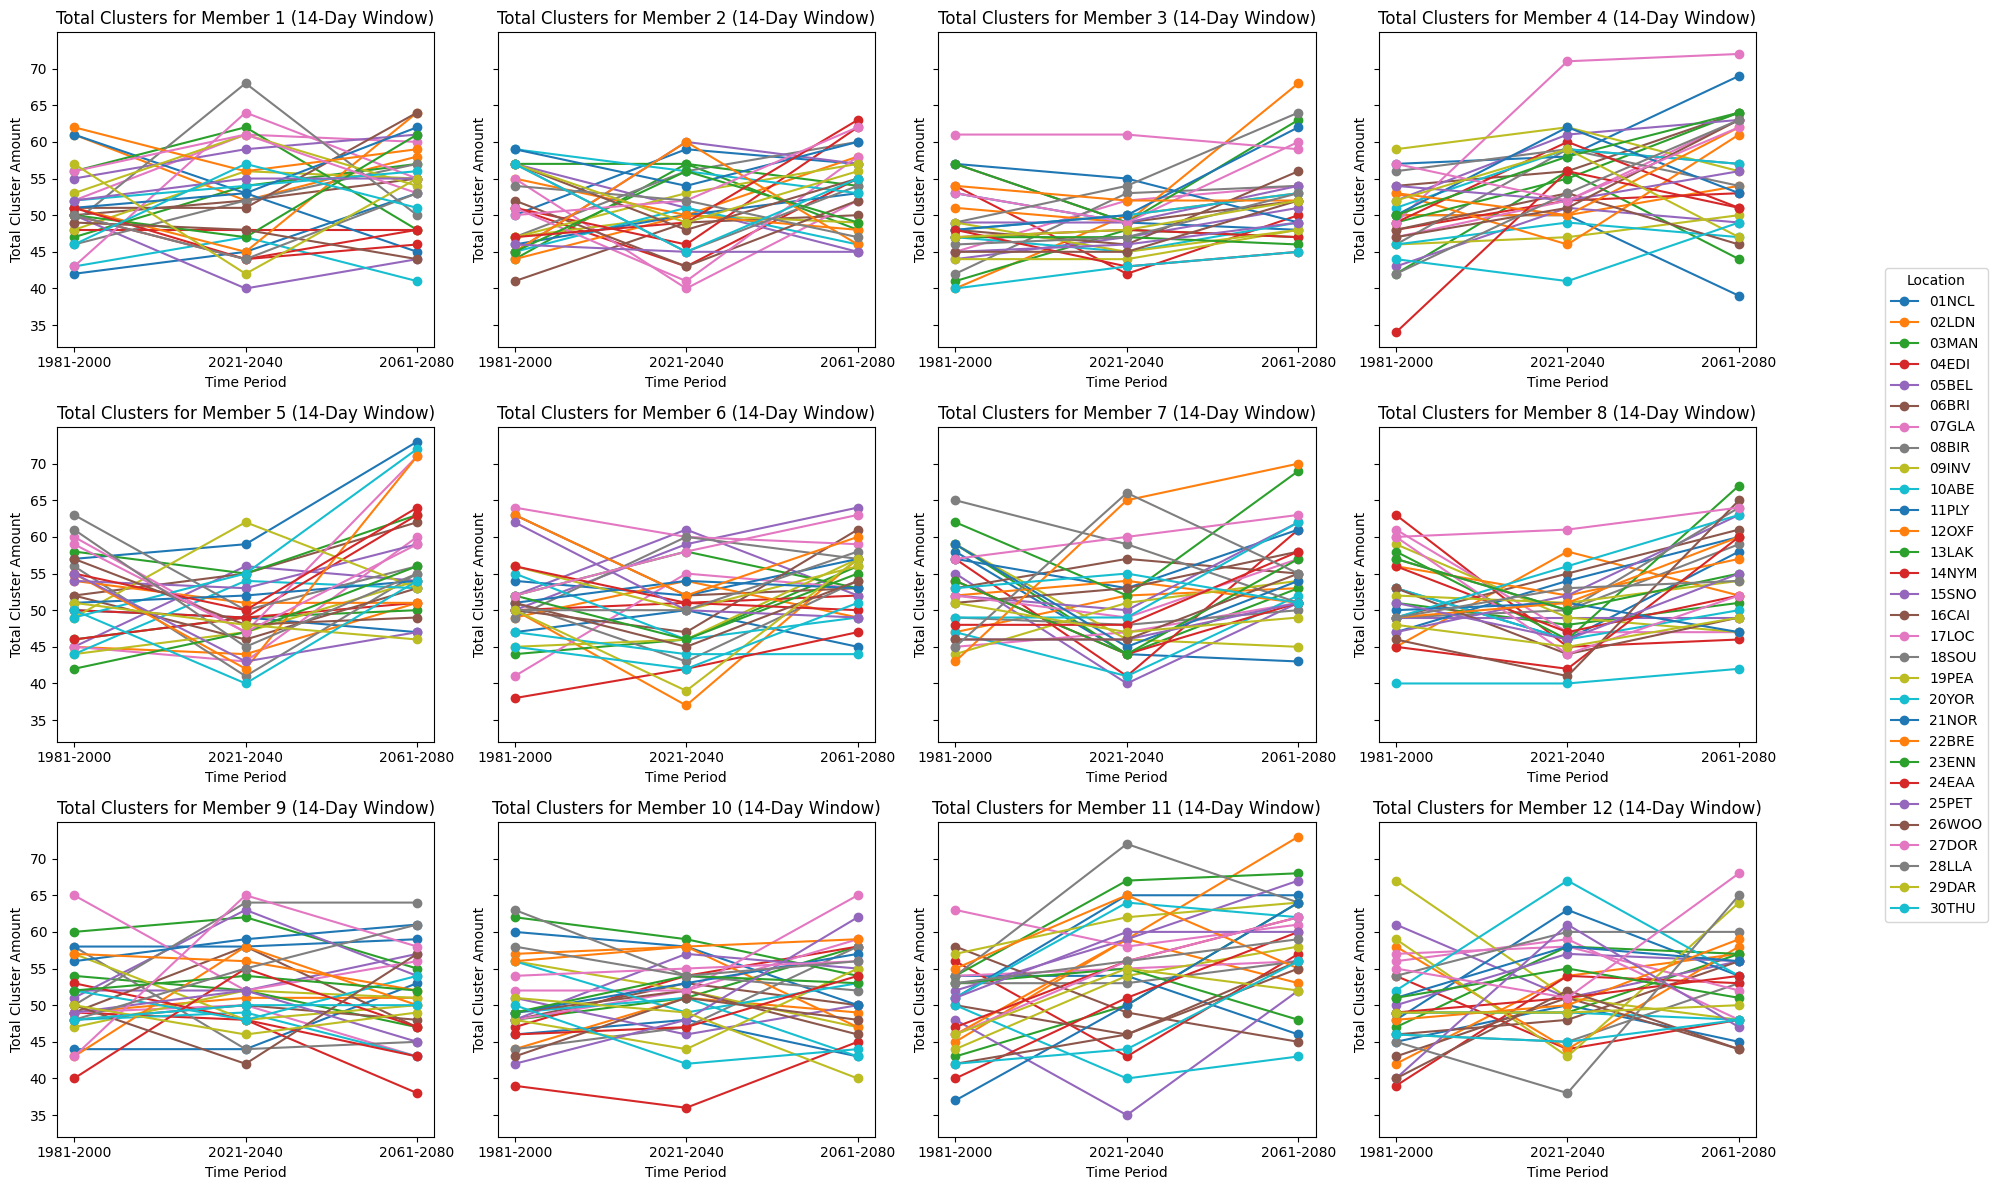

In [ ]:
#All member plots for total number of clusters (14 day window)
window_14 = all_results[all_results['Window'] == 14]
x_labels = ['1981-2000', '2021-2040', '2061-2080']

fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(18, 12), sharey=True)
axs = axs.flatten()

for member in range(1, 13):
    member_data = window_14[window_14['Member'] == member]
    clusters_by_location_period = member_data.groupby(['Location/Timeframe'])['Total Cluster Amount'].sum().reset_index()
    clusters_pivoted = clusters_by_location_period.pivot_table(values='Total Cluster Amount', index='Location/Timeframe', columns=None)

    location_names = clusters_pivoted.index.str.split('_').str[0].unique()

    clusters_by_location = {}
    for location in location_names:
        location_data = clusters_pivoted.loc[clusters_pivoted.index.str.startswith(location)]
        clusters_by_location[location] = location_data

    ax = axs[member-1]
    for location, data in clusters_by_location.items():
        ax.plot(x_labels, data.values, marker='o', label=location)
    ax.set_xlabel('Time Period')
    ax.set_ylabel('Total Cluster Amount')
    ax.set_title(f'Total Clusters for Member {member} (14-Day Window)')

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, title='Location', bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0.0)

plt.tight_layout()
plt.show()


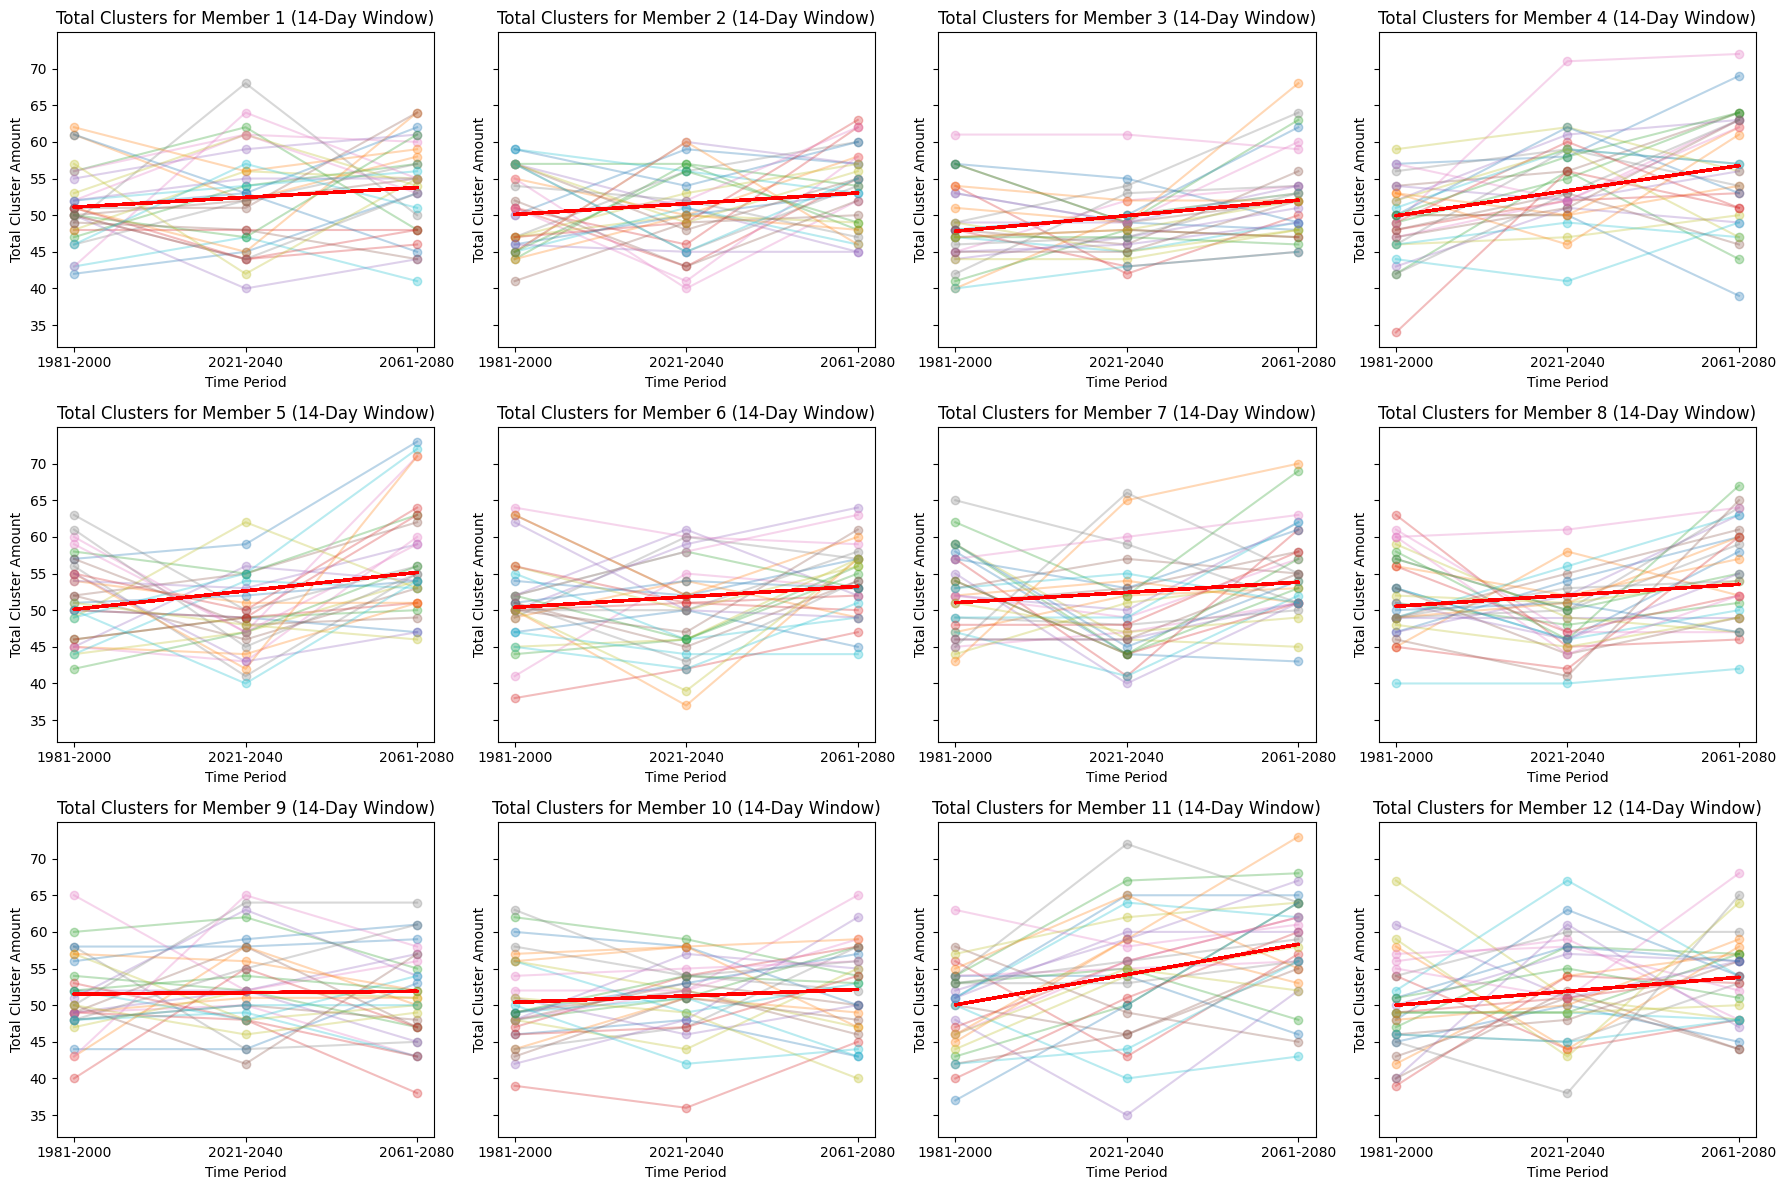

In [ ]:
#All member plots for total number of clusters in 14-day window (With Trendline)
x_labels = ['1981-2000', '2021-2040', '2061-2080']

x_numeric = [0, 1, 2] 

fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(18, 12), sharey=True)
axs = axs.flatten()

for member in range(1, 13):
    member_data = window_14[window_14['Member'] == member]

    clusters_by_location_period = member_data.groupby(['Location/Timeframe'])['Total Cluster Amount'].sum().reset_index()
    clusters_pivoted = clusters_by_location_period.pivot_table(values='Total Cluster Amount', index='Location/Timeframe', columns=None)
    location_names = clusters_pivoted.index.str.split('_').str[0].unique()

    clusters_by_location = {}
    for location in location_names:
        location_data = clusters_pivoted.loc[clusters_pivoted.index.str.startswith(location)]
        clusters_by_location[location] = location_data

    x_values = []
    y_values = []
    for location, data in clusters_by_location.items():
        x_values.extend(x_numeric)
        y_values.extend(data.values)

    x_values = np.array(x_values).flatten()
    y_values = np.array(y_values).flatten()

    z = np.polyfit(x_values, y_values, 1)
    p = np.poly1d(z)

    ax = axs[member-1]
    for location, data in clusters_by_location.items():
        ax.plot(x_numeric, data.values, marker='o', alpha=0.3)

    ax.plot(x_values, p(x_values), "r:", linewidth=2)
    ax.set_xticks(x_numeric)
    ax.set_xticklabels(x_labels)
    ax.set_xlabel('Time Period')
    ax.set_ylabel('Total Cluster Amount')
    ax.set_title(f'Total Clusters for Member {member} (14-Day Window)')

plt.tight_layout()
plt.show()

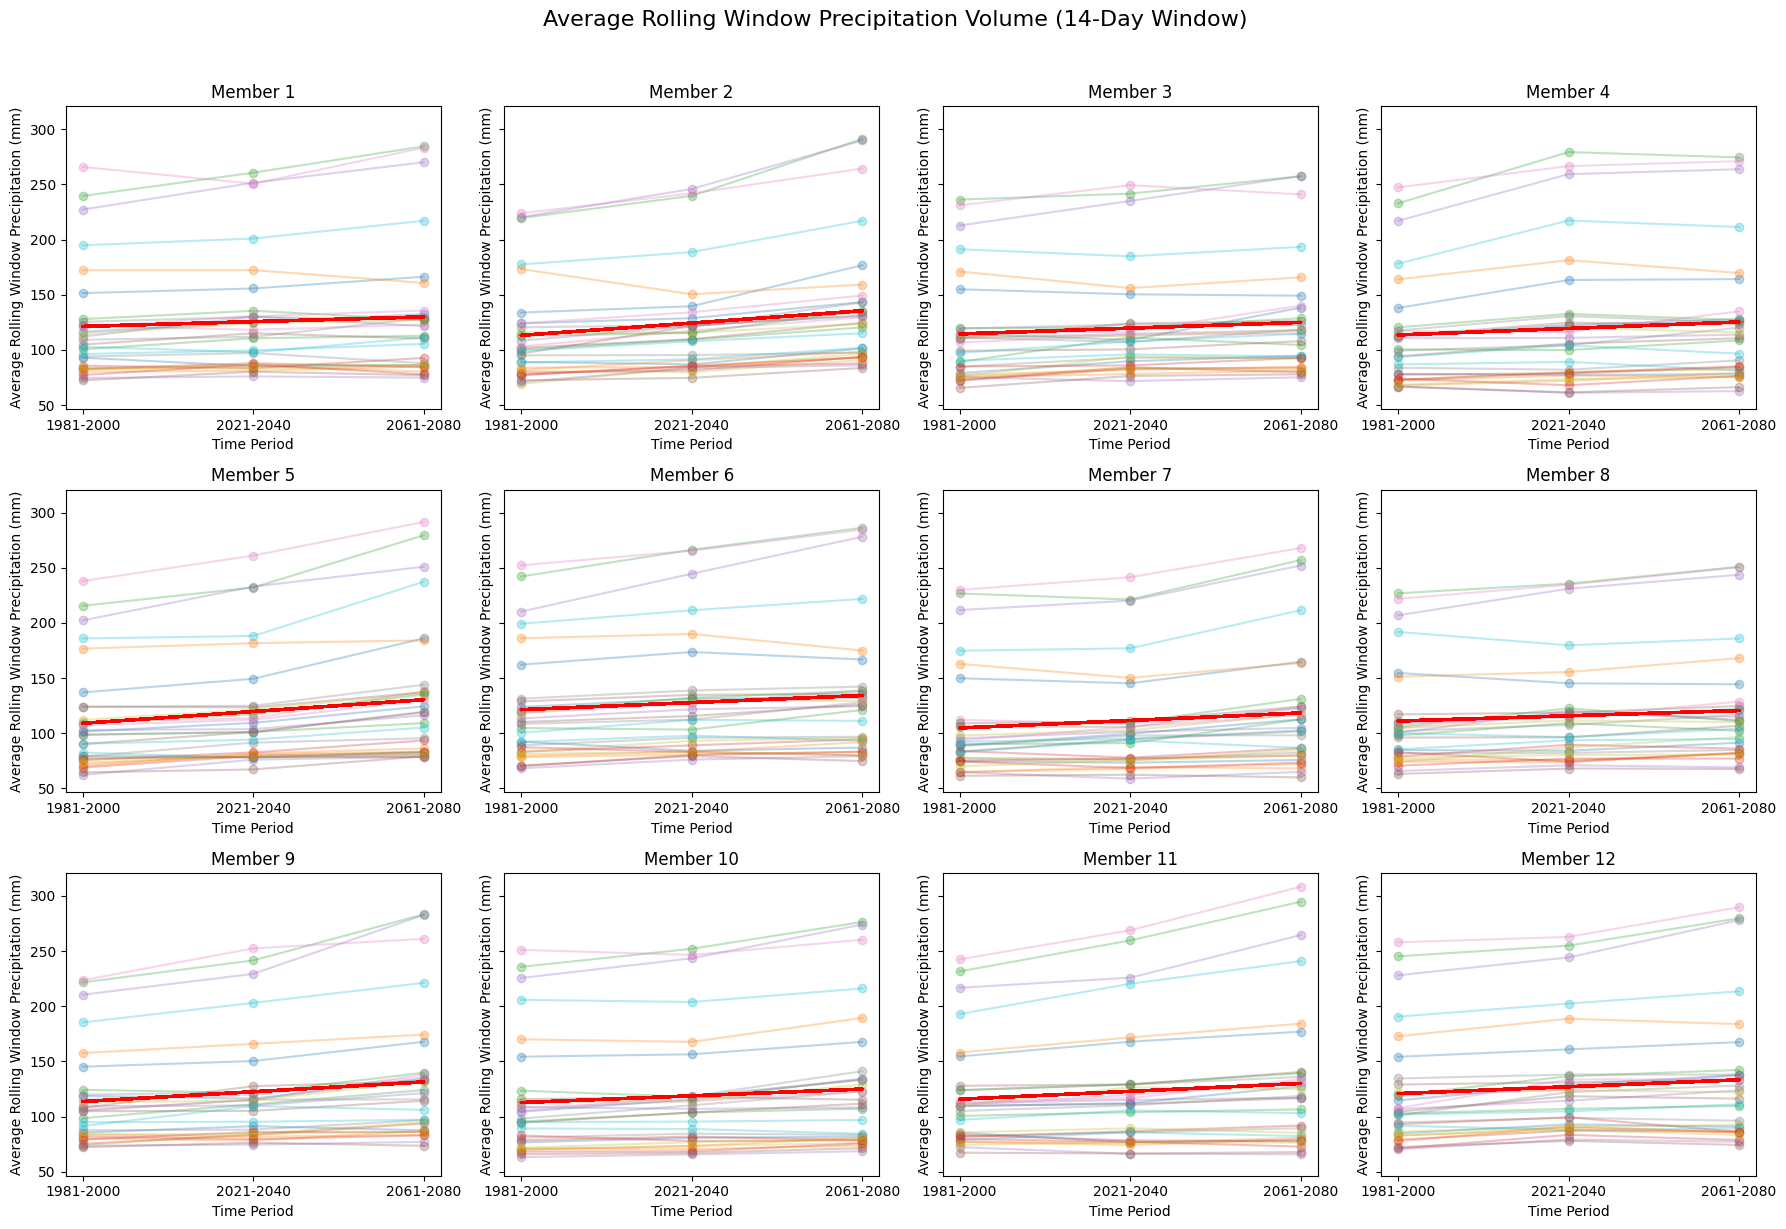

In [ ]:
#All member plots for Average volume of Precipitation in cluster change (with trendline)
x_numeric = [0, 1, 2]  

fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(18, 12), sharey=True)
fig.suptitle('Average Rolling Window Precipitation Volume (14-Day Window)', fontsize=16, y=1.02)
axs = axs.flatten()

for member in range(1, 13):

    member_data = window_14[window_14['Member'] == member]

    avgP_by_location_period = member_data.groupby(['Location/Timeframe'])['Avg Rolling Window P'].mean().reset_index()

    avgP_pivoted = avgP_by_location_period.pivot_table(values='Avg Rolling Window P', index='Location/Timeframe', columns=None)

    location_names = avgP_pivoted.index.str.split('_').str[0].unique()

    avgP_by_location = {}
    for location in location_names:
        location_data = avgP_pivoted.loc[avgP_pivoted.index.str.startswith(location)]
        avgP_by_location[location] = location_data

    x_values = []
    y_values = []
    for location, data in avgP_by_location.items():
        x_values.extend(x_numeric)
        y_values.extend(data.values)

    x_values = np.array(x_values).flatten()
    y_values = np.array(y_values).flatten()

    z = np.polyfit(x_values, y_values, 1)
    p = np.poly1d(z)

    ax = axs[member-1]
    for location, data in avgP_by_location.items():
        ax.plot(x_numeric, data.values, marker='o', alpha=0.3)

    ax.plot(x_values, p(x_values), "r:", linewidth=2)
    ax.set_xticks(x_numeric)
    ax.set_xticklabels(x_labels)
    ax.set_xlabel('Time Period')
    ax.set_ylabel('Average Rolling Window Precipitation (mm)')
    ax.set_title(f'Member {member}', fontsize=12)

plt.tight_layout()
plt.show()

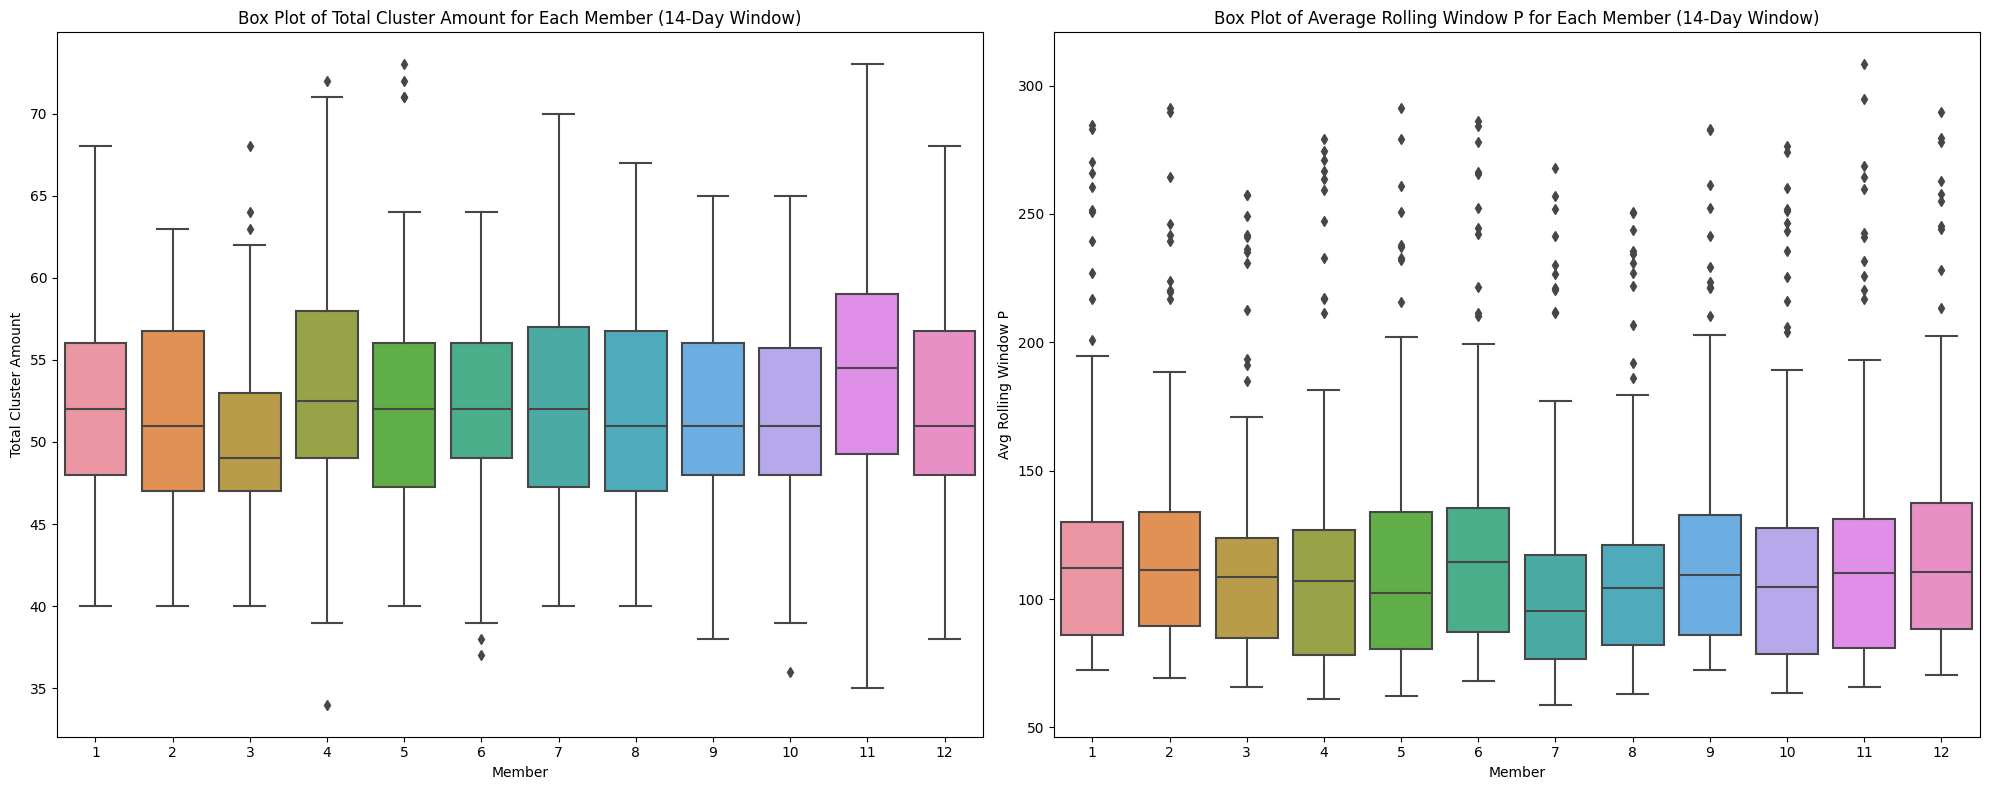

In [ ]:
#box plot with 'Member' on the x-axis and 'Total Cluster Amount' on the y-axis
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

sns.boxplot(x='Member', y='Total Cluster Amount', data=window_14, ax=ax1)
ax1.set_xlabel('Member')
ax1.set_ylabel('Total Cluster Amount')
ax1.set_title('Box Plot of Total Cluster Amount for Each Member (14-Day Window)')

sns.boxplot(x='Member', y='Avg Rolling Window P', data=window_14, ax=ax2)
ax2.set_xlabel('Member')
ax2.set_ylabel('Avg Rolling Window P')
ax2.set_title('Box Plot of Average Volume of Precipitation in Cluster for Each Member (14-Day Window)')

plt.tight_layout()
plt.show()

In [ ]:
#Calculations for working out percentage change and absolute change across 2070s to 1990s
all_results_window14 = all_results[all_results['Window'] == 14]
clusterpivot_df = all_results_window14.pivot_table(index='Location/Timeframe', columns='Member', values='Total Cluster Amount')
rollingPpivot_df = all_results_window14.pivot_table(index='Location/Timeframe', columns='Member', values='Avg Rolling Window P')
mean_dispersion_pivot = all_results_window14.pivot_table(index='Location/Timeframe', columns='Member', values='Mean Dispersion')


locations = all_results_window14.index.str.split('_').str[0].unique()


totalclusterdelta_dict = {}
totalclusterpercent_dict = {}
avgRollingPdelta_dict = {}
avgRollingPpercent_dict = {}
mean_dispersion_delta_dict = {}
mean_dispersion_percent_dict = {}


for location in locations:
    clusterlocation_data = clusterpivot_df.loc[clusterpivot_df.index.str.startswith(location)]
    rollinglocation_data = rollingPpivot_df.loc[rollingPpivot_df.index.str.startswith(location)]
    mean_dispersion_location_data = mean_dispersion_pivot.loc[mean_dispersion_pivot.index.str.startswith(location)]


    deltacluster = clusterlocation_data.loc[location + '_2061_2080'] - clusterlocation_data.loc[location + '_1981_2000']
    deltaRollingP = rollinglocation_data.loc[location + '_2061_2080'] - rollinglocation_data.loc[location + '_1981_2000']
    delta_mean_dispersion = mean_dispersion_location_data.loc[location + '_2061_2080'] - mean_dispersion_location_data.loc[location + '_1981_2000']

    totalclusterdelta_dict[location] = deltacluster
    avgRollingPdelta_dict[location] = deltaRollingP
    mean_dispersion_delta_dict[location] = delta_mean_dispersion

    clusterpercent_change = (deltacluster / clusterlocation_data.loc[location + '_1981_2000']) * 100
    rollingpercent_change = (deltaRollingP / rollinglocation_data.loc[location + '_1981_2000']) * 100
    mean_dispersion_percent_change = (delta_mean_dispersion / mean_dispersion_location_data.loc[location + '_1981_2000']) * 100

    totalclusterpercent_dict[location] = clusterpercent_change
    avgRollingPpercent_dict[location] = rollingpercent_change
    mean_dispersion_percent_dict[location] = mean_dispersion_percent_change

deltatotalcluster_df = pd.DataFrame(totalclusterdelta_dict).T
percenttotalcluster_df = pd.DataFrame(totalclusterpercent_dict).T
deltaAvgRollingP_df = pd.DataFrame(avgRollingPdelta_dict).T
percentAvgRollingP_df = pd.DataFrame(avgRollingPpercent_dict).T
delta_mean_dispersion_df = pd.DataFrame(mean_dispersion_delta_dict).T
percent_mean_dispersion_df = pd.DataFrame(mean_dispersion_percent_dict).T

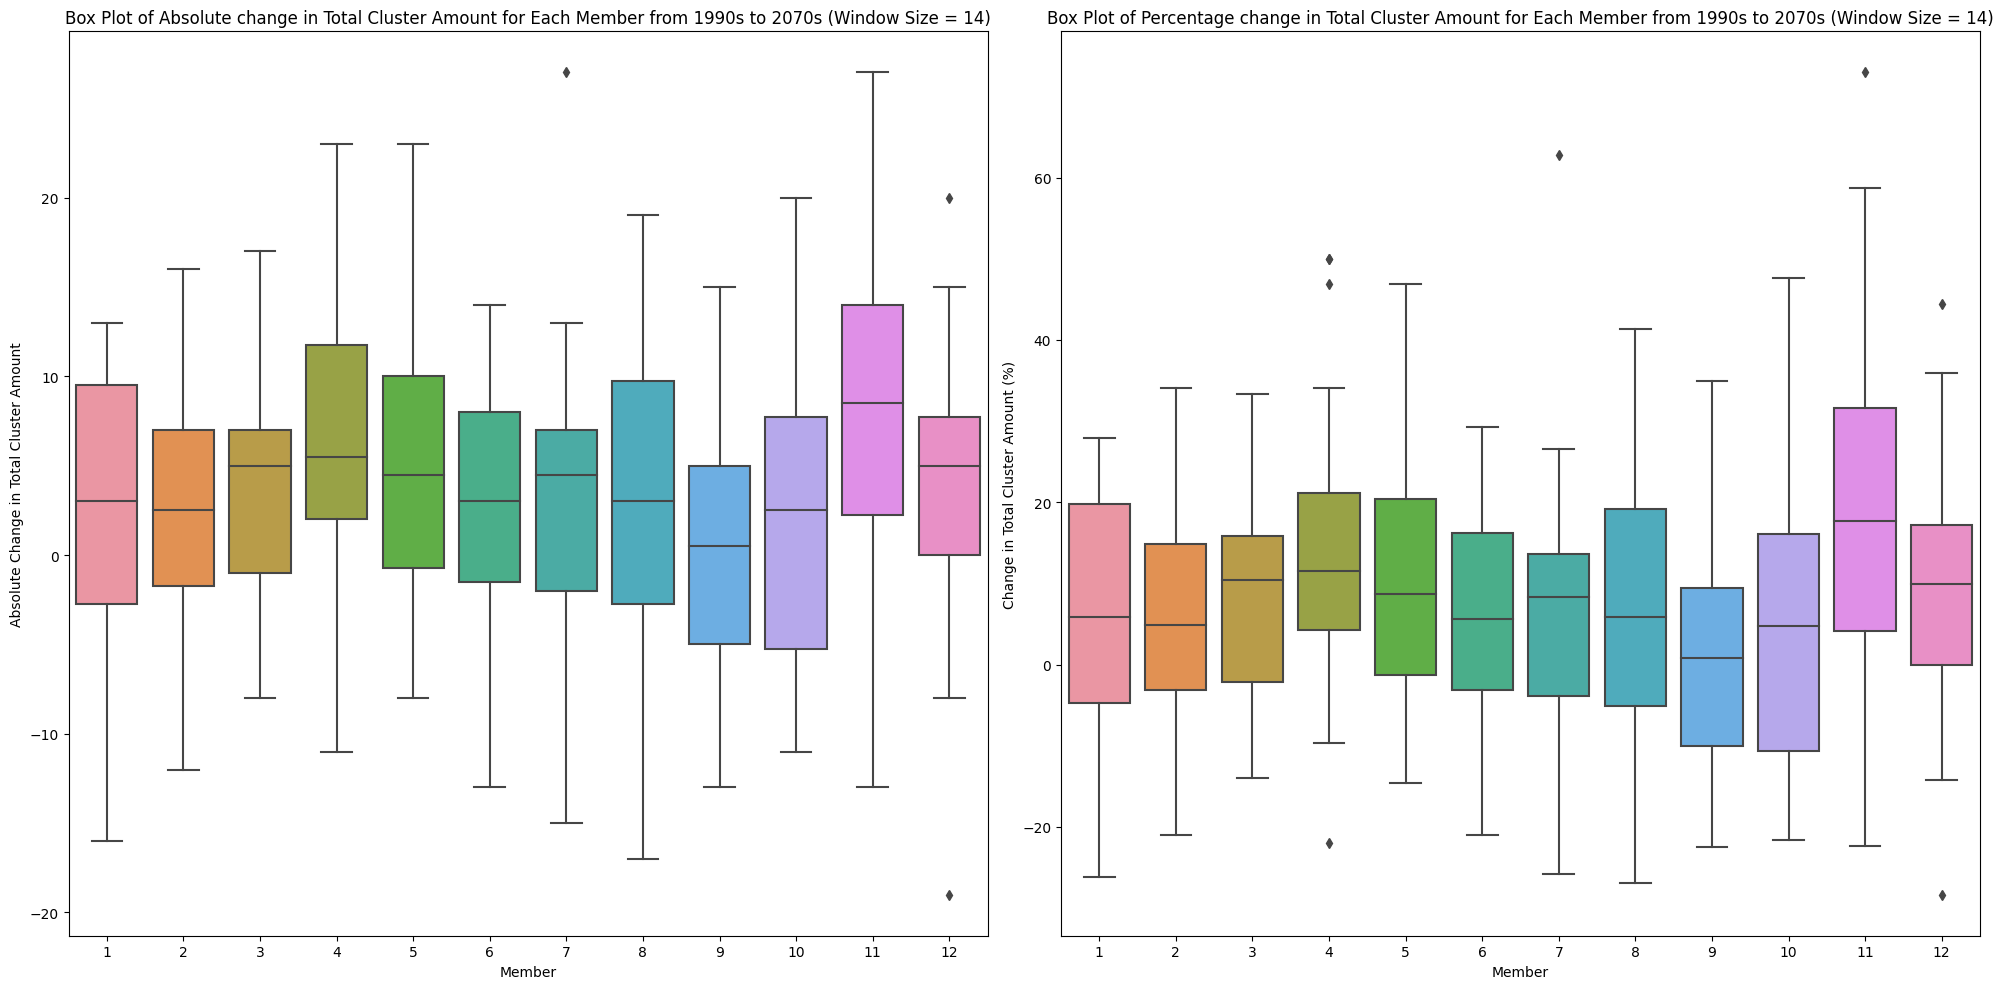

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

# Boxplot 1: deltatotalcluster_df
sns.boxplot(data=deltatotalcluster_df, ax=axes[0])
axes[0].set_xticklabels(deltatotalcluster_df.columns)
axes[0].set_title('Box Plot of Absolute change in Total Cluster Amount for Each Member from 1990s to 2070s (Window Size = 14)')
axes[0].set_ylabel('Absolute Change in Total Cluster Amount')
axes[0].set_xlabel('Member')

# Boxplot 2: percenttotalcluster_df
sns.boxplot(data=percenttotalcluster_df, ax=axes[1])
axes[1].set_xticklabels(percenttotalcluster_df.columns)
axes[1].set_title('Box Plot of Percentage change in Total Cluster Amount for Each Member from 1990s to 2070s (Window Size = 14)')
axes[1].set_ylabel('Change in Total Cluster Amount (%)')
axes[1].set_xlabel('Member')

plt.tight_layout()
plt.show()

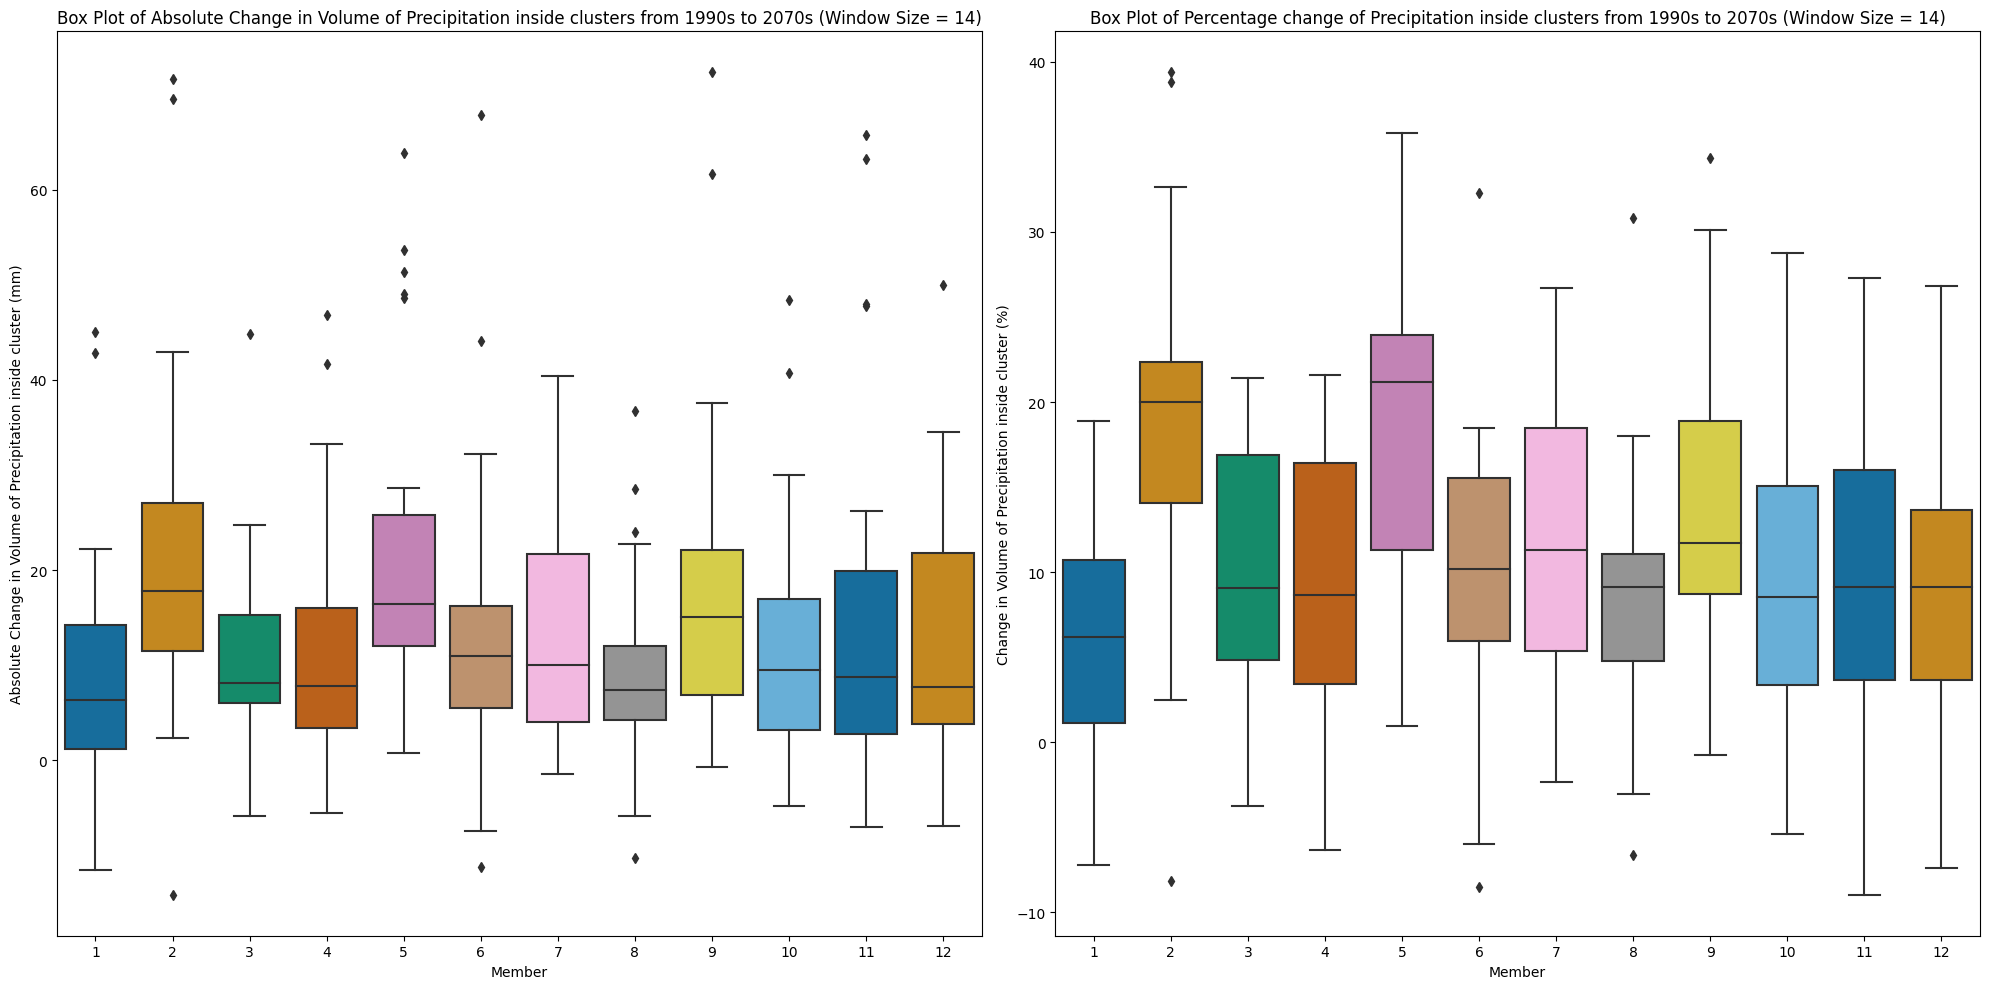

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

# Boxplot 1: deltaAvgRollingP_df
sns.boxplot(data=deltaAvgRollingP_df, ax=axes[0], palette='colorblind')
axes[0].set_xticklabels(deltaAvgRollingP_df.columns)
axes[0].set_title('Box Plot of Absolute Change in Volume of Precipitation inside clusters from 1990s to 2070s (Window Size = 14)')
axes[0].set_ylabel('Absolute Change in Volume of Precipitation inside cluster (mm)')
axes[0].set_xlabel('Member')

# Boxplot 2: percentAvgRollingP_df
sns.boxplot(data=percentAvgRollingP_df, ax=axes[1], palette='colorblind')
axes[1].set_xticklabels(percentAvgRollingP_df.columns)
axes[1].set_title('Box Plot of Percentage change of Precipitation inside clusters from 1990s to 2070s (Window Size = 14)')
axes[1].set_ylabel('Change in Volume of Precipitation inside cluster (%)')
axes[1].set_xlabel('Member')

plt.tight_layout()
plt.show()

<ipython-input-116-7e3e638f0ee8>:12: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  all_results_member12['Longitude'], all_results_member12['Latitude'] = transform(inProj, outProj, all_results_member12['coord1'], all_results_member12['coord2'])
<ipython-input-116-7e3e638f0ee8>:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap1 = plt.cm.get_cmap('magma_r')
<ipython-input-116-7e3e638f0ee8>:44: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap2 = plt.cm.get_cmap('viridis_r')


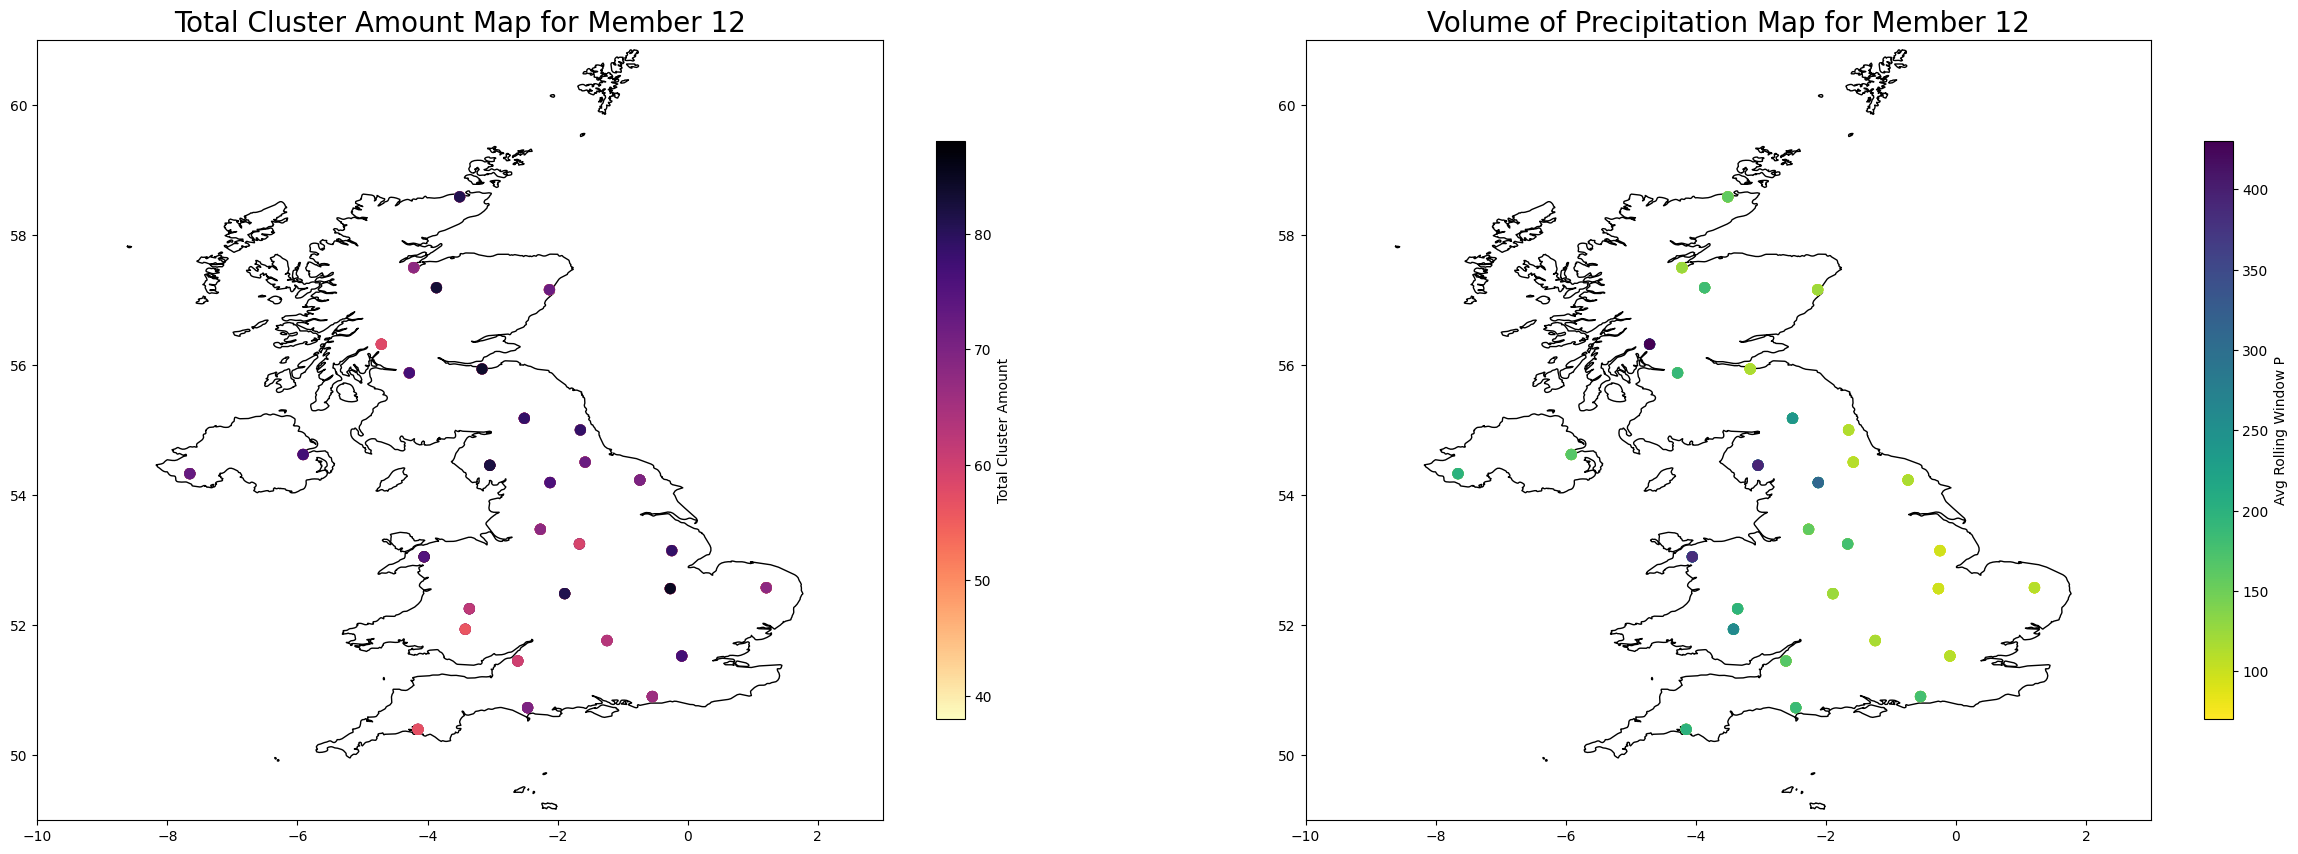

In [ ]:
# Plotting maps for Cluster amount and volume of P in Member 12 - Using transform PyProj module
inProj = Proj('epsg:27700')  # British National Grid (UKCP18 coordinate format)
outProj = Proj('epsg:4326')  # WGS84

all_results_member12 = all_results[all_results['Member'] == 12].copy()

all_results_member12[['coord1', 'coord2']] = pd.DataFrame(all_results_member12['Coordinates'].tolist(), index=all_results_member12.index)

all_results_member12['Longitude'], all_results_member12['Latitude'] = transform(inProj, outProj, all_results_member12['coord1'], all_results_member12['coord2'])

# Creating GeoDataFrame
geometry = [Point(xy) for xy in zip(all_results_member12['Latitude'], all_results_member12['Longitude'])]
gdf_member12 = gpd.GeoDataFrame(all_results_member12, geometry=geometry)

#UK Shapefile map - received from natural earth website for UK border
gdf_uk = gpd.read_file('/content/drive/MyDrive/ne_10m_admin_0_countries.zip')

uk = gdf_uk[gdf_uk['SOVEREIGNT'] == 'United Kingdom']

fig, axs = plt.subplots(1, 2, figsize=(30,25))

norm1 = mcolors.Normalize(vmin=all_results_member12['Total Cluster Amount'].min(), vmax=all_results_member12['Total Cluster Amount'].max())
cmap1 = plt.cm.get_cmap('magma_r') 
all_results_member12['Color1'] = [cmap1(norm1(value)) for value in all_results_member12['Total Cluster Amount']]

axs[0].set_xlim(-10, 3)  
axs[0].set_ylim(49, 61)  
axs[0].set_title("Total Cluster Amount Map for Member 12", fontsize=20)

uk.plot(ax=axs[0], color='white', edgecolor='black')
gdf_member12.plot(ax=axs[0], markersize=50, color=all_results_member12['Color1'], marker='o') 

sm1 = plt.cm.ScalarMappable(cmap=cmap1, norm=norm1)
sm1.set_array([])
fig.colorbar(sm1, ax=axs[0], orientation='vertical', label='Total Cluster Amount', shrink=0.3)

norm2 = mcolors.Normalize(vmin=all_results_member12['Avg Rolling Window P'].min(), vmax=all_results_member12['Avg Rolling Window P'].max())
cmap2 = plt.cm.get_cmap('viridis_r') 
all_results_member12['Color2'] = [cmap2(norm2(value)) for value in all_results_member12['Avg Rolling Window P']]

axs[1].set_xlim(-10, 3) 
axs[1].set_ylim(49, 61) 
axs[1].set_title("Volume of Precipitation Map for Member 12", fontsize=20)

uk.plot(ax=axs[1], color='white', edgecolor='black')
gdf_member12.plot(ax=axs[1], markersize=50, color=all_results_member12['Color2'], marker='o') 

sm2 = plt.cm.ScalarMappable(cmap=cmap2, norm=norm2)
sm2.set_array([])
fig.colorbar(sm2, ax=axs[1], orientation='vertical', label='Avg Rolling Window P', shrink=0.3)

plt.show()

In [ ]:
all_14Window_1981_2000 = all_results[(all_results['Window'] == 14) & (all_results.index.str.contains('1981_2000'))]
all_14Window_2021_2040 = all_results[(all_results['Window'] == 14) & (all_results.index.str.contains('2021_2040'))]
all_14Window_2061_2080 = all_results[(all_results['Window'] == 14) & (all_results.index.str.contains('2061_2080'))]

# Percentile Calculations
mean_14_1981_2000 = all_14Window_1981_2000.groupby('Location/Timeframe').agg({
    'Total Cluster Amount': 'mean',
    'Avg Rolling Window P': 'mean',
    'Mean Dispersion': 'mean',
    'Coordinates': 'first'  
}).reset_index()

mean_14_2021_2040 = all_14Window_2021_2040.groupby('Location/Timeframe').agg({
    'Total Cluster Amount': 'mean',
    'Avg Rolling Window P': 'mean',
    'Mean Dispersion': 'mean',
    'Coordinates': 'first' 
}).reset_index()

mean_14_2061_2080 = all_14Window_2061_2080.groupby('Location/Timeframe').agg({
    'Total Cluster Amount': 'mean',
    'Avg Rolling Window P': 'mean',
    'Mean Dispersion': 'mean',
    'Coordinates': 'first' 
}).reset_index()

<ipython-input-104-be504cc2e88f>:8: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  mean_14_1981_2000['Longitude'], mean_14_1981_2000['Latitude'] = transform(inProj, outProj, mean_14_1981_2000['coord1'], mean_14_1981_2000['coord2'])
<ipython-input-104-be504cc2e88f>:13: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  mean_14_2021_2040['Longitude'], mean_14_2021_2040['Latitude'] = transform(inProj, outProj, mean_14_2021_2040['coord1'], mean_14_2021_2040['coord2'])
<ipython-input-104-be504cc2e88f>:18: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  mean_14_2061_2080['Longitude'], mean_14_2061_2080['Latitude'] = transform(inProj, outProj, mean_14_2061_2080['coord1'], mean_14_2061_2080['coord2'])


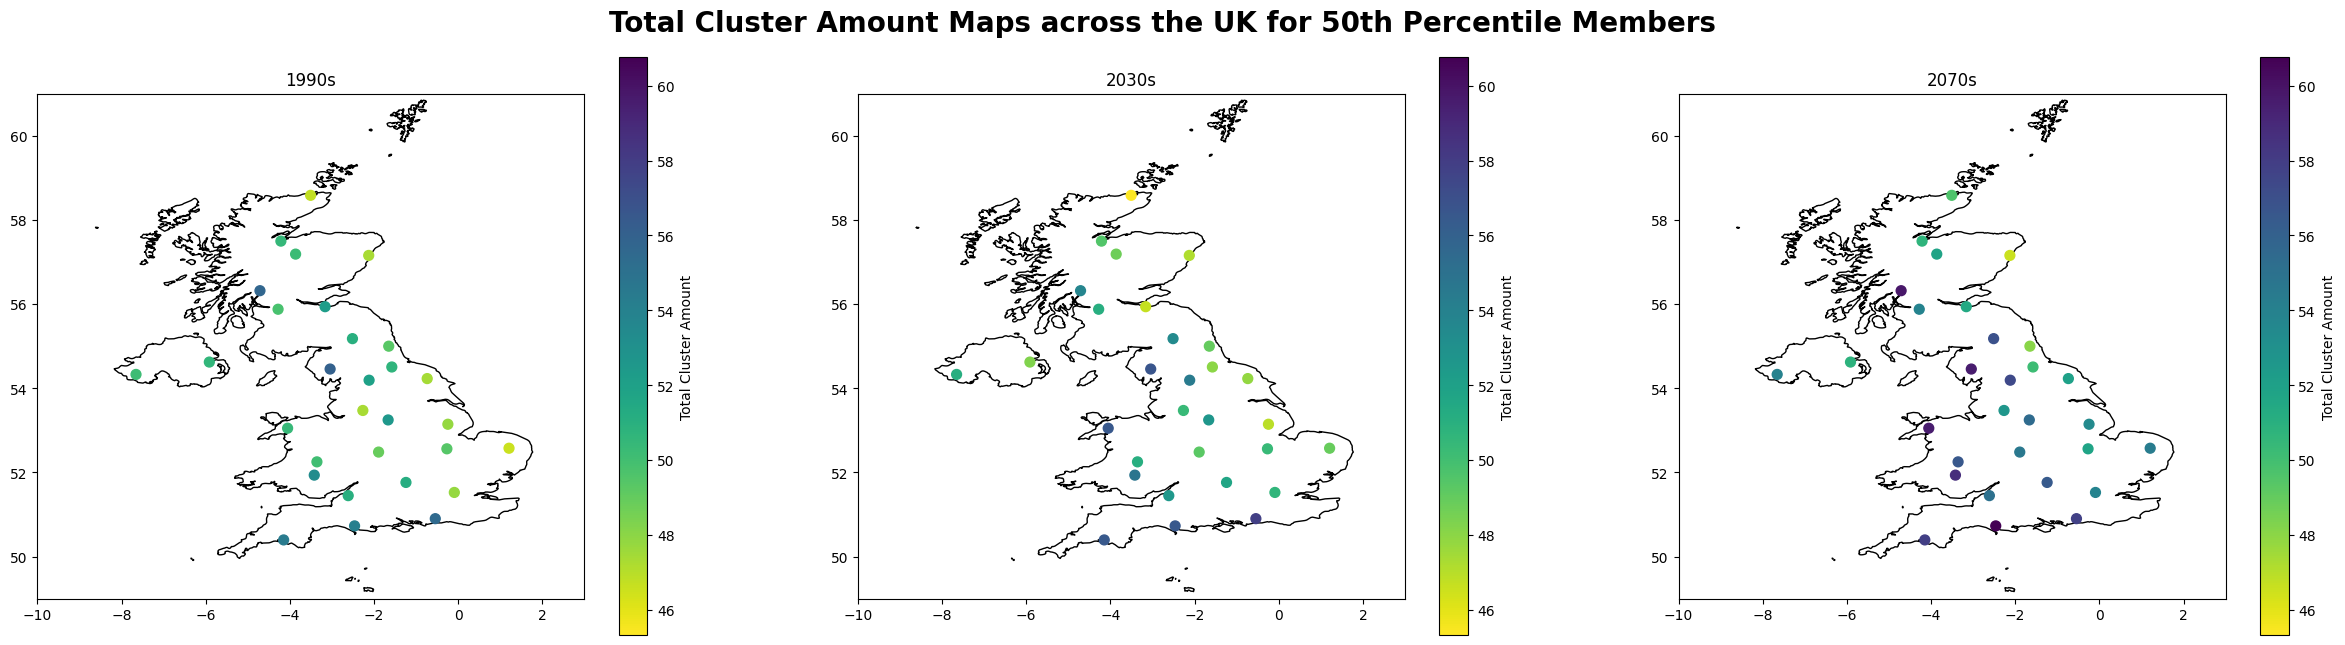

In [ ]:
#3 Cluster amount maps for 50th percentile members across the designated timeframes - 1990s, 2030s and 2070s
inProj = Proj('epsg:27700')  # British National Grid
outProj = Proj('epsg:4326')  # WGS84


# 1981-2000
mean_14_1981_2000['Longitude'], mean_14_1981_2000['Latitude'] = transform(inProj, outProj, mean_14_1981_2000['coord1'], mean_14_1981_2000['coord2'])
geometry_1981_2000 = [Point(xy) for xy in zip(mean_14_1981_2000['Latitude'], mean_14_1981_2000['Longitude'])]
gdf_1981_2000 = gpd.GeoDataFrame(mean_14_1981_2000, geometry=geometry_1981_2000)

# 2021-2040
mean_14_2021_2040['Longitude'], mean_14_2021_2040['Latitude'] = transform(inProj, outProj, mean_14_2021_2040['coord1'], mean_14_2021_2040['coord2'])
geometry_2021_2040 = [Point(xy) for xy in zip(mean_14_2021_2040['Latitude'], mean_14_2021_2040['Longitude'])]
gdf_2021_2040 = gpd.GeoDataFrame(mean_14_2021_2040, geometry=geometry_2021_2040)

# 2061-2080
mean_14_2061_2080['Longitude'], mean_14_2061_2080['Latitude'] = transform(inProj, outProj, mean_14_2061_2080['coord1'], mean_14_2061_2080['coord2'])
geometry_2061_2080 = [Point(xy) for xy in zip(mean_14_2061_2080['Latitude'], mean_14_2061_2080['Longitude'])]
gdf_2061_2080 = gpd.GeoDataFrame(mean_14_2061_2080, geometry=geometry_2061_2080)



fig, axs = plt.subplots(1, 3, figsize=(30,30))
gdf_uk = gpd.read_file('/content/drive/MyDrive/ne_10m_admin_0_countries.zip')
uk = gdf_uk[gdf_uk['SOVEREIGNT'] == 'United Kingdom']


min_val = min(mean_14_1981_2000['Total Cluster Amount'].min(), 
              mean_14_2021_2040['Total Cluster Amount'].min(), 
              mean_14_2061_2080['Total Cluster Amount'].min())
max_val = max(mean_14_1981_2000['Total Cluster Amount'].max(), 
              mean_14_2021_2040['Total Cluster Amount'].max(), 
              mean_14_2061_2080['Total Cluster Amount'].max())

cmap = mpl.cm.viridis_r
norm = mpl.colors.Normalize(vmin=min_val, vmax=max_val)


uk.plot(ax=axs[0], color='white', edgecolor='black')

im1 = gdf_1981_2000.plot(ax=axs[0], markersize=50, column='Total Cluster Amount', cmap=cmap, norm=norm, legend=False)

axs[0].set_aspect('equal')
axs[0].set_title('1990s')
axs[0].set_xlim(-10, 3) 
axs[0].set_ylim(49, 61) 
#axs[0].set_position([0.35, 0.15, 0.3, 0.7])

# Plot for '2021_2040'
uk.plot(ax=axs[1], color='white', edgecolor='black')
im2 = gdf_2021_2040.plot(ax=axs[1], markersize=50, column='Total Cluster Amount', cmap=cmap, norm=norm, legend=False)

axs[1].set_aspect('equal')
axs[1].set_title('2030s')
axs[1].set_xlim(-10, 3)  
axs[1].set_ylim(49, 61)  
#axs[1].set_position([0.35, 0.15, 0.3, 0.7])

# Plot for '2061_2080'
uk.plot(ax=axs[2], color='white', edgecolor='black')
im3 = gdf_2061_2080.plot(ax=axs[2], markersize=50, column='Total Cluster Amount', cmap=cmap, norm=norm, legend=False)

axs[2].set_aspect('equal')
axs[2].set_title('2070s')
axs[2].set_xlim(-10, 3) 
axs[2].set_ylim(49, 61)  
#axs[2].set_position([0.35, 0.15, 0.3, 0.7])

# Create a ScalarMappable object for the colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])


cbar1 = fig.colorbar(sm, ax=axs[0], orientation='vertical', shrink=0.25, label='Total Cluster Amount')
cbar2 = fig.colorbar(sm, ax=axs[1], orientation='vertical', shrink=0.25, label='Total Cluster Amount')
cbar3 = fig.colorbar(sm, ax=axs[2], orientation='vertical', shrink=0.25, label='Total Cluster Amount')

title = fig.text(0.5, 0.6, 'Total Cluster Amount Maps across the UK for 50th Percentile Members', 
                 fontsize=20, fontweight='bold', ha='center')

plt.show()


<ipython-input-106-4c2cf90d4998>:18: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  percentiles_14_2061_2080['Longitude'], percentiles_14_2061_2080['Latitude'] = transform(inProj, outProj, percentiles_14_2061_2080['coord1'], percentiles_14_2061_2080['coord2'])
<ipython-input-106-4c2cf90d4998>:40: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap(cmaps[i])
<ipython-input-106-4c2cf90d4998>:40: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap(cmaps[i])
<ipython-input-106-4c2cf90d4998>:40: MatplotlibDeprecationWarning: T

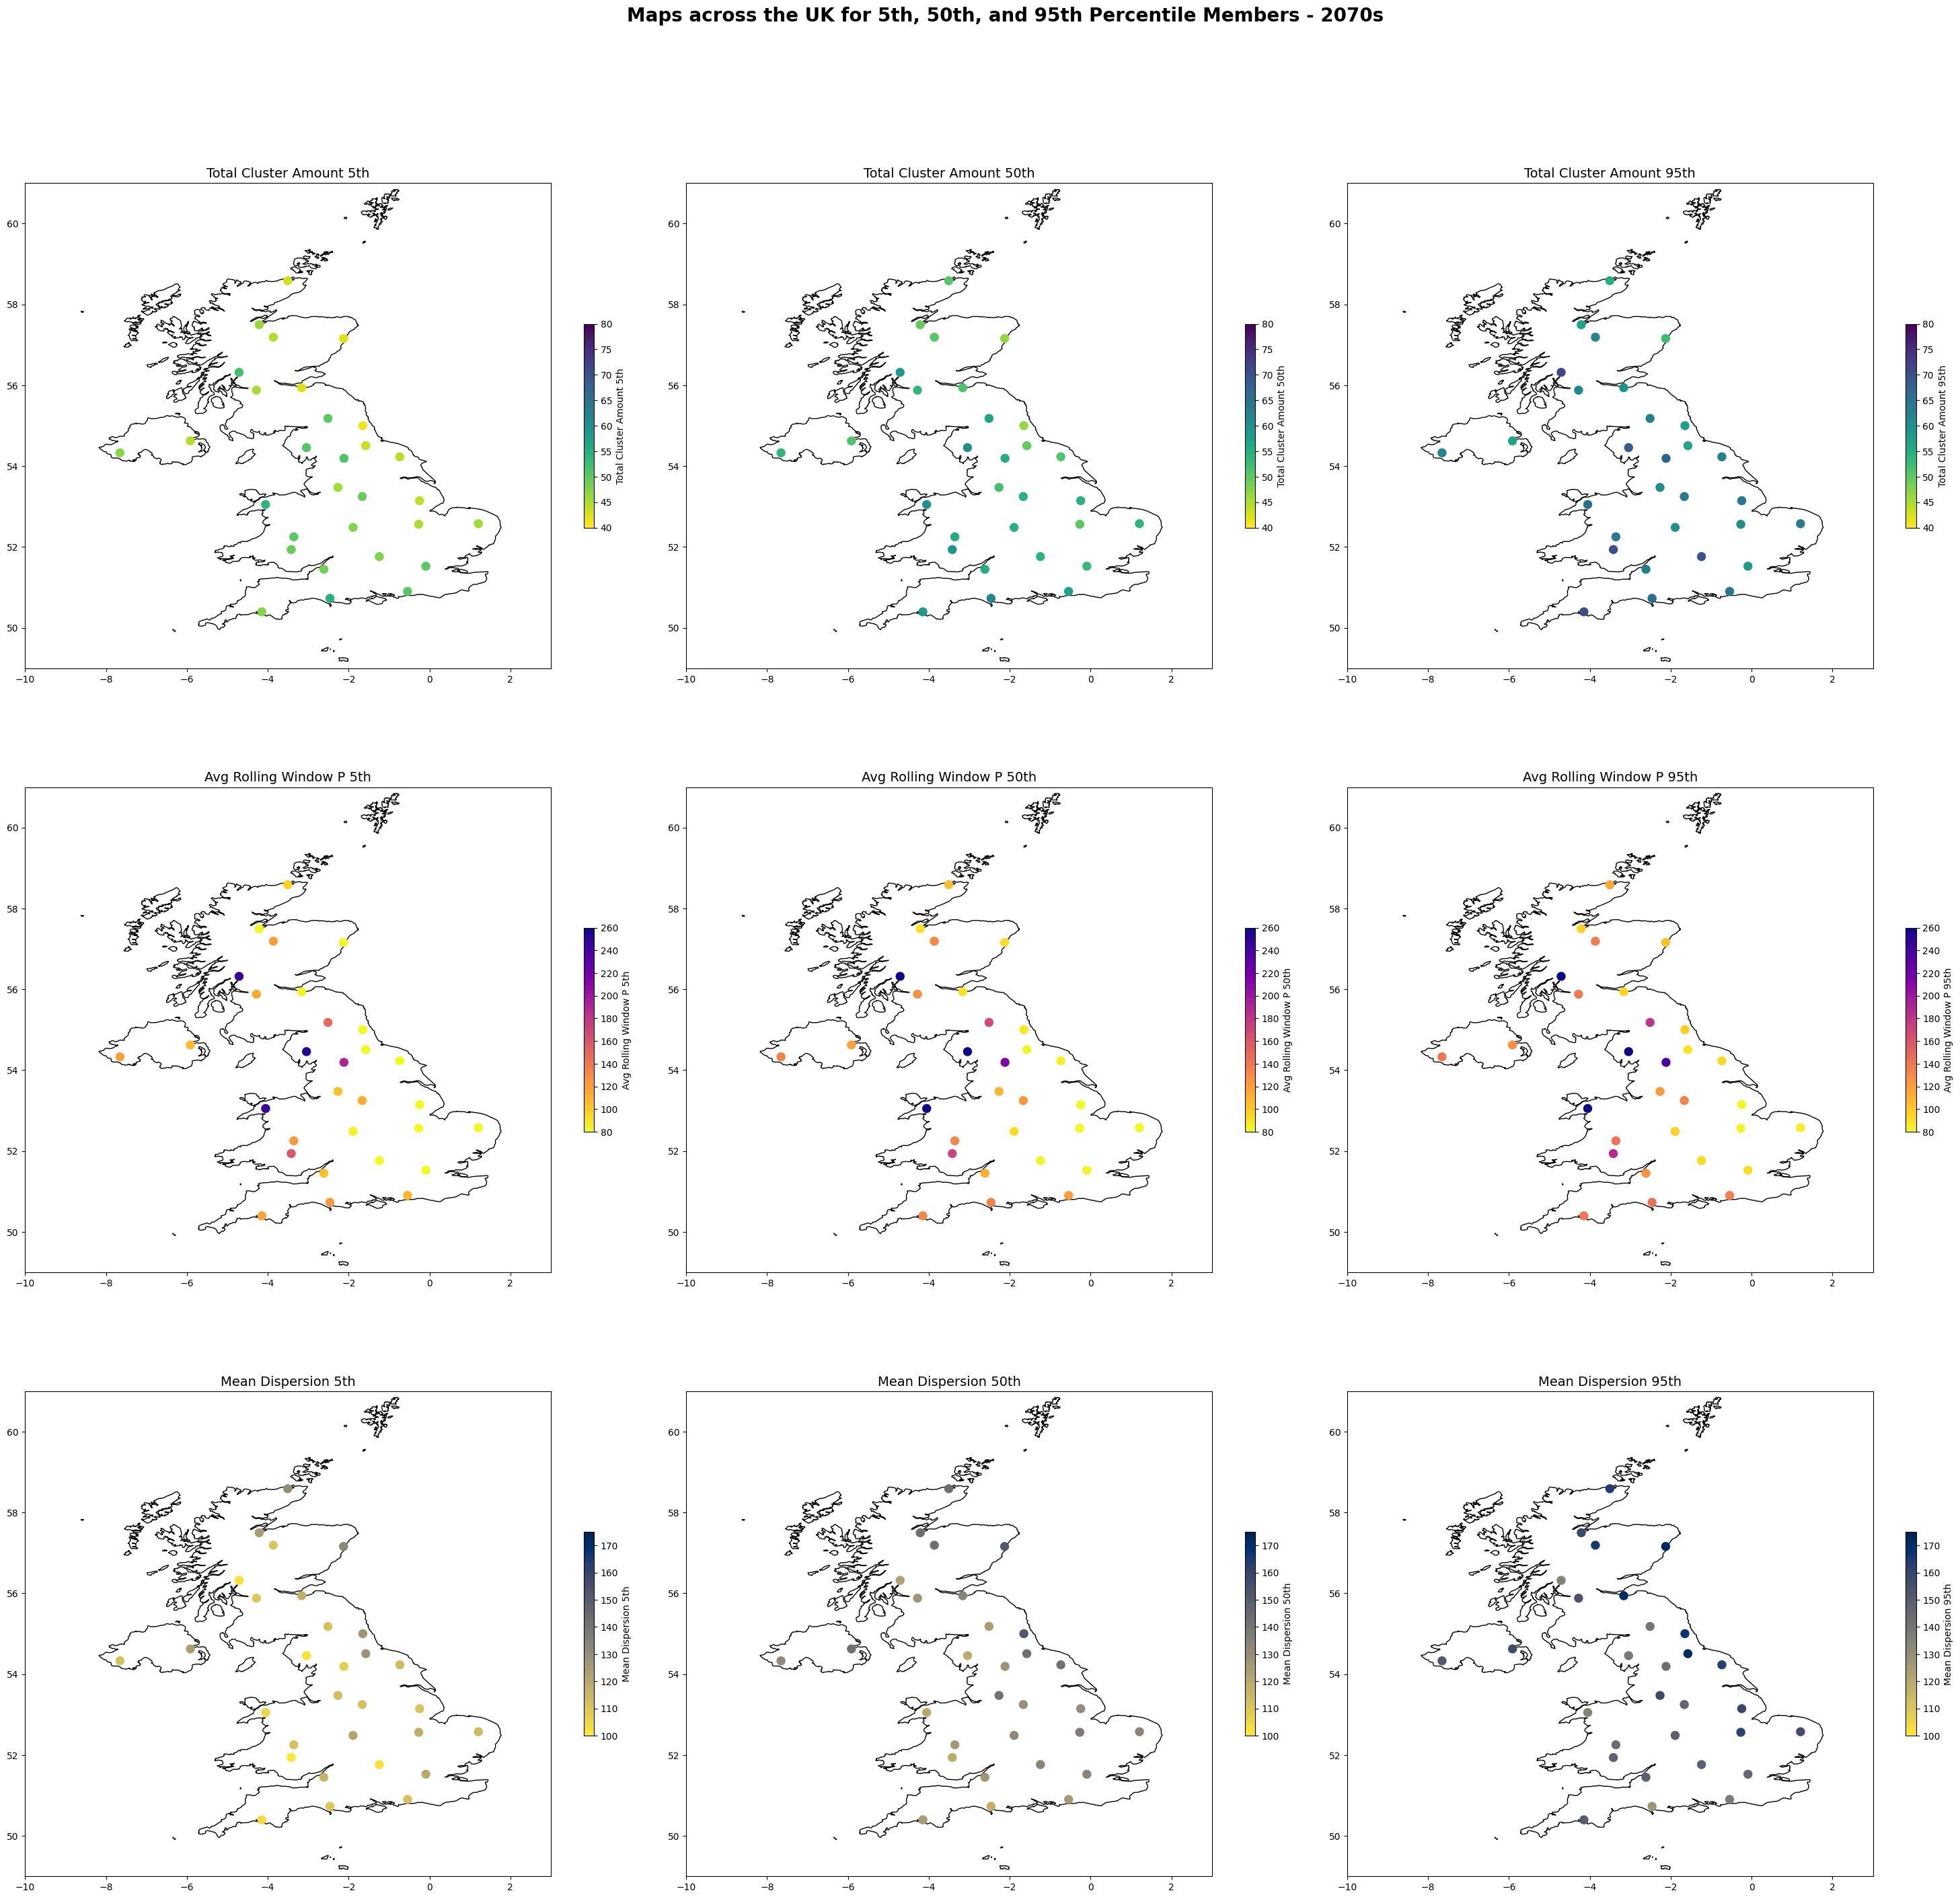

In [ ]:
# 5th 50th and 95h Percentile member maps for Dispersion, Number of Clusters and Volume of Rainfall in Clusters
percentiles_14_2061_2080 = all_14Window_2061_2080.groupby('Location/Timeframe').agg({
    'Total Cluster Amount': [lambda x: np.percentile(x, 5), 'median', lambda x: np.percentile(x, 95)],
    'Avg Rolling Window P': [lambda x: np.percentile(x, 5), 'median', lambda x: np.percentile(x, 95)],
    'Mean Dispersion': [lambda x: np.percentile(x, 5), 'median', lambda x: np.percentile(x, 95)],
    'Coordinates': 'first'  # Assuming all coordinates are the same for each location, we just take the first one
}).reset_index()

# Renaming the columns
percentiles_14_2061_2080.columns = ['Location/Timeframe', 
                                    'Total Cluster Amount 5th', 'Total Cluster Amount 50th', 'Total Cluster Amount 95th',
                                    'Avg Rolling Window P 5th', 'Avg Rolling Window P 50th', 'Avg Rolling Window P 95th',
                                    'Mean Dispersion 5th', 'Mean Dispersion 50th', 'Mean Dispersion 95th', 
                                    'Coordinates']

# Converting Coordinates
percentiles_14_2061_2080[['coord1', 'coord2']] = pd.DataFrame(percentiles_14_2061_2080['Coordinates'].tolist(), index=percentiles_14_2061_2080.index)
percentiles_14_2061_2080['Longitude'], percentiles_14_2061_2080['Latitude'] = transform(inProj, outProj, percentiles_14_2061_2080['coord1'], percentiles_14_2061_2080['coord2'])
geometry_2061_2080 = [Point(xy) for xy in zip(percentiles_14_2061_2080['Latitude'], percentiles_14_2061_2080['Longitude'])]
gdf_2061_2080 = gpd.GeoDataFrame(percentiles_14_2061_2080, geometry=geometry_2061_2080)

# Create subplots
fig, axs = plt.subplots(3, 3, figsize=(30,30))

# Define the metrics and percentiles
metrics = ['Total Cluster Amount', 'Avg Rolling Window P', 'Mean Dispersion']
percentiles = ['5th', '50th', '95th']

# List of colormaps
cmaps = ['viridis_r', 'plasma_r', 'cividis_r']

# Define the minimum and maximum values for each metric
min_values = [40, 80, 100]  
max_values = [80, 260, 175]  

# Loop through all metrics and percentiles
for i, metric in enumerate(metrics):
    for j, percentile in enumerate(percentiles):
        # Define the colormap
        cmap = mpl.cm.get_cmap(cmaps[i])

        # Define the norm
        norm = mpl.colors.Normalize(vmin=min_values[i], vmax=max_values[i])

        # Plot
        uk.plot(ax=axs[i, j], color='white', edgecolor='black')
        im = gdf_2061_2080.plot(ax=axs[i, j], markersize=75, column=f'{metric} {percentile}', cmap=cmap, norm=norm, legend=False)

        axs[i, j].set_title(f'{metric} {percentile}', fontsize=14)
        axs[i, j].set_xlim(-10, 3)  # Adjust the values as needed to focus on the UK region
        axs[i, j].set_ylim(49, 61)  # Adjust the values as needed to focus on the UK region

        # Create a ScalarMappable object for the colorbar
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])

        # Create colorbar
        cbar = fig.colorbar(sm, ax=axs[i, j], orientation='vertical', shrink=0.3, label=f'{metric} {percentile}')

# Add mega title
title = fig.suptitle('Maps across the UK for 5th, 50th, and 95th Percentile Members - 2070s', fontsize=20, fontweight='bold')

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to make space for the title
plt.show()



In [ ]:
# Calculate percentiles for the percentage changes to better represent on geopandas maps
percent_percentiles_ClusterAmount_df = percenttotalcluster_df.quantile([0.05, 0.5, 0.95], axis=1).T
percent_percentiles_AvgRollingP_df = percentAvgRollingP_df.quantile([0.05, 0.5, 0.95], axis=1).T
percent_percentiles_Dispersion_df = percent_mean_dispersion_df.quantile([0.05, 0.5, 0.95], axis=1).T

percent_percentiles_ClusterAmount_df.columns = ['% Change in 5th percentile member', '% Change in 50th percentile member', '% Change in 95th percentile member']
percent_percentiles_AvgRollingP_df.columns = ['% Change in 5th percentile member', '% Change in 50th percentile member', '% Change in 95th percentile member']
percent_percentiles_Dispersion_df.columns = ['% Change in 5th percentile member', '% Change in 50th percentile member', '% Change in 95th percentile member']


percent_percentiles_Dispersion_df = percent_percentiles_Dispersion_df.reset_index(drop=True)
percent_percentiles_ClusterAmount_df = percent_percentiles_ClusterAmount_df.reset_index(drop=True)
percent_percentiles_AvgRollingP_df = percent_percentiles_AvgRollingP_df.reset_index(drop=True)


percent_percentiles_Dispersion_df = pd.concat([percent_percentiles_Dispersion_df, gdf_2061_2080[['Longitude', 'Latitude']]], axis=1)
percent_percentiles_ClusterAmount_df = pd.concat([percent_percentiles_ClusterAmount_df, gdf_2061_2080[['Longitude', 'Latitude']]], axis=1)
percent_percentiles_AvgRollingP_df = pd.concat([percent_percentiles_AvgRollingP_df, gdf_2061_2080[['Longitude', 'Latitude']]], axis=1)


<ipython-input-140-5da57dc71d73>:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap(cmaps[i])
<ipython-input-140-5da57dc71d73>:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap(cmaps[i])
<ipython-input-140-5da57dc71d73>:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap(cmaps[i])
<ipython-input-140-5da57dc71d73>:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be

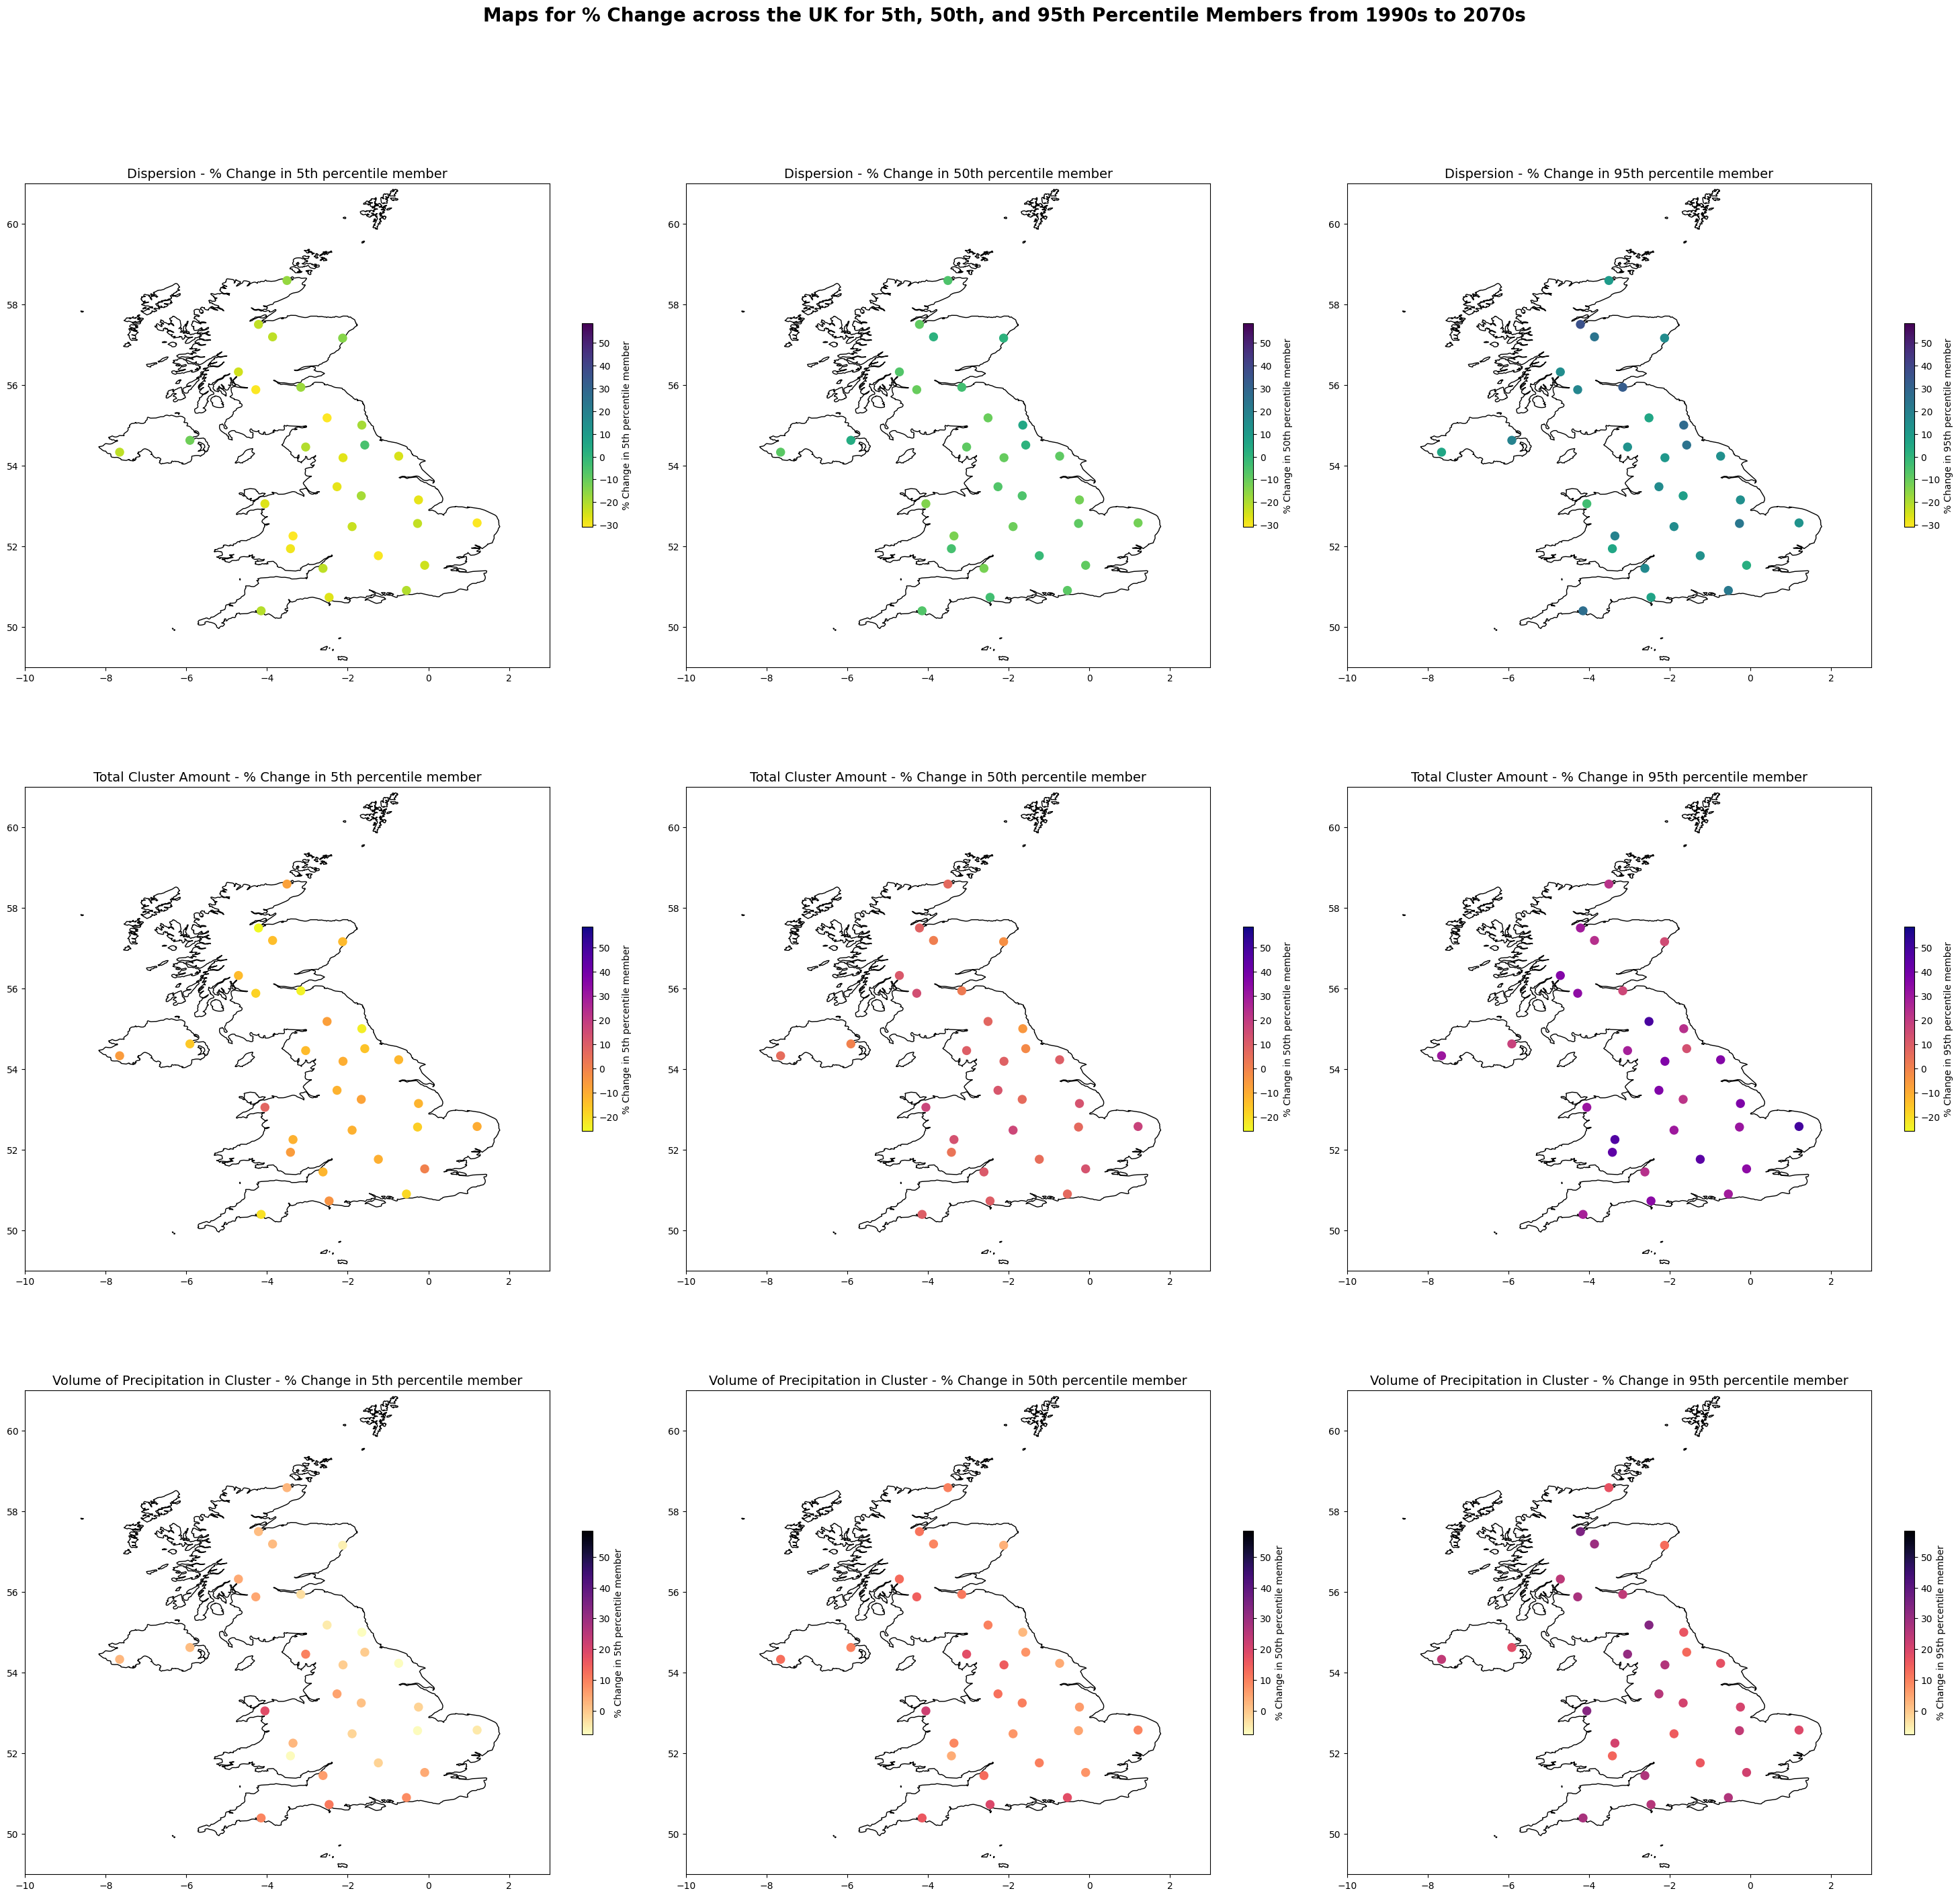

In [ ]:
# Create subplots
fig, axs = plt.subplots(3, 3, figsize=(30, 30))


metrics = ['Dispersion', 'Total Cluster Amount', 'Volume of Precipitation in Cluster']
percentile_dfs = [percent_percentiles_Dispersion_df, percent_percentiles_ClusterAmount_df, percent_percentiles_AvgRollingP_df]
percentiles = ['% Change in 5th percentile member', '% Change in 50th percentile member', '% Change in 95th percentile member']

cmaps = ['viridis_r', 'plasma_r', 'magma_r']

min_values = [df.min().min() for df in percentile_dfs]
max_values = [df.max().max() for df in percentile_dfs]

for i, metric in enumerate(metrics):
    for j, percentile in enumerate(percentiles):
        cmap = mpl.cm.get_cmap(cmaps[i])

        norm = mpl.colors.Normalize(vmin=min_values[i], vmax=max_values[i])

        uk.plot(ax=axs[i, j], color='white', edgecolor='black')
        im = axs[i, j].scatter(percentile_dfs[i]['Latitude'], percentile_dfs[i]['Longitude'], s=75, c=percentile_dfs[i][percentile], cmap=cmap, norm=norm)

        axs[i, j].set_title(f'{metric} - {percentile}', fontsize=14)
        axs[i, j].set_xlim(-10, 3)  
        axs[i, j].set_ylim(49, 61)  

        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])

        cbar = fig.colorbar(sm, ax=axs[i, j], orientation='vertical', shrink=0.3, label=percentile)

title = fig.suptitle('Maps for % Change across the UK for 5th, 50th, and 95th Percentile Members from 1990s to 2070s', fontsize=20, fontweight='bold')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

